In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.spatial.distance import pdist, squareform

%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os
from dask.diagnostics import ProgressBar
import duckdb

sys.path.append("../scripts")
from initial_map import BarcodeMapper
from map_refiner import MapRefiner
import preprocess

In [2]:
cc_step1_fasta = "../data/Staller_Tl4s1_MVS_0035_I1TTGTCACCAA_CGCACGAACA_S326.fastq.gz.assembled.fastq"
cc_step1_fasta

'../data/Staller_Tl4s1_MVS_0035_I1TTGTCACCAA_CGCACGAACA_S326.fastq.gz.assembled.fastq'

In [3]:
# ! pip install umi_tools

In [5]:
refiner = MapRefiner(db_path = "../duckdb/CC_nkx2_2_try2",
                      cols = ["ADBC2", "HawkBCs", "RTBC", "AD"],
                     reads_threshold = 5,
                     column_pairs = [("AD", ("ADBC2", "HawkBCs")), (("ADBC2", "HawkBCs"), "RTBC")])

In [6]:
mapper = BarcodeMapper(seq_file = ['../data/Staller_Tl4s1_MVS_0035_I1TTGTCACCAA_CGCACGAACA_S326.fastq.gz.assembled.fastq'],
                        design_file_path = "../data/DNA_Tiles_nkx2_2.txt",
                        bc_names = ["ADBC2", "HawkBCs", "RTBC", "AD"],
                        preceders = ["CTCGAGATAACTTCGTATAATGTATGCTAT", "GAGCTCGCTAGC", "GGCCGGCCATAGGGCCCC", "CACCATG"],
                        posts = ["GGCCGGCCATAGGGCCCC", "CTCGAGATAA", "GCGGTCCA", "GGATCCG"],
                        lengths = [6, 9, 16, 162],
                      reverse_complement=False)
mapped_df = mapper.create_map()
mapped_df.head()

Shortening ../data/Staller_Tl4s1_MVS_0035_I1TTGTCACCAA_CGCACGAACA_S326.fastq.gz.assembled.fastq -> reads_shortened.txt
('reads_shortened.txt',)


,ADBC2,ADBC2_qual,HawkBCs,HawkBCs_qual,RTBC,RTBC_qual,AD,AD_qual,Designed
0,<NA>,False,<NA>,False,<NA>,False,<NA>,False,0.0
1,<NA>,False,ACCAAGATC,True,<NA>,False,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,0.0
2,<NA>,False,<NA>,False,<NA>,False,<NA>,False,0.0
3,<NA>,False,<NA>,False,<NA>,False,<NA>,False,0.0
4,<NA>,False,<NA>,False,<NA>,False,<NA>,False,0.0


In [ ]:
# only show y ticsk once for 

In [10]:
refiner.refine_map_from_parquet('../output/CC_nkx2_2.parquet/*')

Refining maps: 100%|██████████| 5/5 [00:01<00:00,  2.80step/s]


In [1]:
#refiner.create_map1_initial('../output/CC_nkx2_2.parquet/*')
initial = refiner.get_map_df('map1_initial')
initial

NameError: name 'refiner' is not defined

In [12]:
# How similar are ADBC2s?

In [16]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm

def hamming_distance(seq1, seq2):
    """Compute Hamming distance between two equal-length sequences."""
    return sum(c1 != c2 for c1, c2 in zip(seq1, seq2))

def nearest_neighbor(seq_idx, seq_list):
    """Compute the minimum distance and nearest neighbor for seq_list[seq_idx]."""
    seq = seq_list[seq_idx]
    min_dist = None
    nearest_seq = None
    
    for j, other_seq in enumerate(seq_list):
        if j == seq_idx:
            continue  # skip self
        dist = hamming_distance(seq, other_seq)
        if (min_dist is None) or (dist < min_dist):
            min_dist = dist
            nearest_seq = other_seq
            
    return min_dist, nearest_seq

def nearest_neighbors_parallel_df(seq_list, n_jobs=-1):
    """Compute nearest neighbors for all sequences in parallel and return a DataFrame."""
    results = Parallel(n_jobs=n_jobs)(
        delayed(nearest_neighbor)(i, seq_list) for i in tqdm(range(len(seq_list)))
    )
    
    min_dists, neighbors = zip(*results)
    
    df = pd.DataFrame({
        "sequence": seq_list,
        "min_distance_to_other": min_dists,
        "nearest_neighbor": neighbors
    })
    return df

# Example usage
seq_list = ["ATGC", "ATGA", "TTGC", "ATCC", "ATGG"]
df = nearest_neighbors_parallel_df(seq_list)
df

100%|██████████| 5/5 [00:00<00:00, 7546.43it/s]


,sequence,min_distance_to_other,nearest_neighbor
0,ATGC,1,ATGA
1,ATGA,1,ATGC
2,TTGC,1,ATGC
3,ATCC,1,ATGC
4,ATGG,1,ATGC


In [17]:
# What is the distance between ADBC2s?
initial_ADBC2_qual = initial[initial["ADBC2_qual"] == True]
initial_ADBC2_qual_counts = pd.DataFrame(initial_ADBC2_qual["ADBC2"].value_counts()).reset_index()
initial_ADBC2_qual_unique = initial_ADBC2_qual_counts["ADBC2"]
ADBC2_dist = nearest_neighbors_parallel_df(list(initial_ADBC2_qual_unique))
ADBC2_dist

100%|██████████| 1638/1638 [00:01<00:00, 913.18it/s] 


,sequence,min_distance_to_other,nearest_neighbor
0,GTACAA,1,GTACGA
1,AACAAA,1,AAGAAA
2,CCATAA,1,TCATAA
3,TGTGTA,1,TGTATA
4,ACAAGA,1,ACAACA
...,...,...,...
1633,ATGCTT,1,ATGATT
1634,ACCGCT,1,GCCGCT
1635,AAAGAT,1,AAATAT
1636,GCAGGA,1,GAAGGA


In [18]:
ADBC2_dist["min_distance_to_other"].value_counts()

min_distance_to_other
1    1638
Name: count, dtype: int64

In [58]:
# What is the distance between RP BCs?
initial_RTBC_qual = initial[initial["RTBC_qual"] == True]
initial_RTBC_qual_counts = pd.DataFrame(initial_RTBC_qual["RTBC"].value_counts()).reset_index()
initial_RTBC_qual_counts = initial_RTBC_qual_counts["RTBC"]
RTBC_dist = nearest_neighbors_parallel_df(list(initial_RTBC_qual_counts))
RTBC_dist

100%|██████████| 3923/3923 [00:27<00:00, 144.20it/s]


0       CAGCGTTTAACAAGCG
1       GCTATTGACGAGACAA
2       GTGATTTAGTATCTTT
3       TGTAAAATGGGGCTGG
4       TGAAACGTTTAAGGGA
              ...       
3918    GGGTTGTAAGAAAGCG
3919    AGTAAAAGTTCAAATA
3920    CTAGTTAAGCCTATTG
3921    GACTAAAGGATTAGTG
3922    GGAATGGAGATAAAGC
Name: RTBC, Length: 3923, dtype: object

Text(0.5, 0, 'Minimum Hamming Distance to Other')

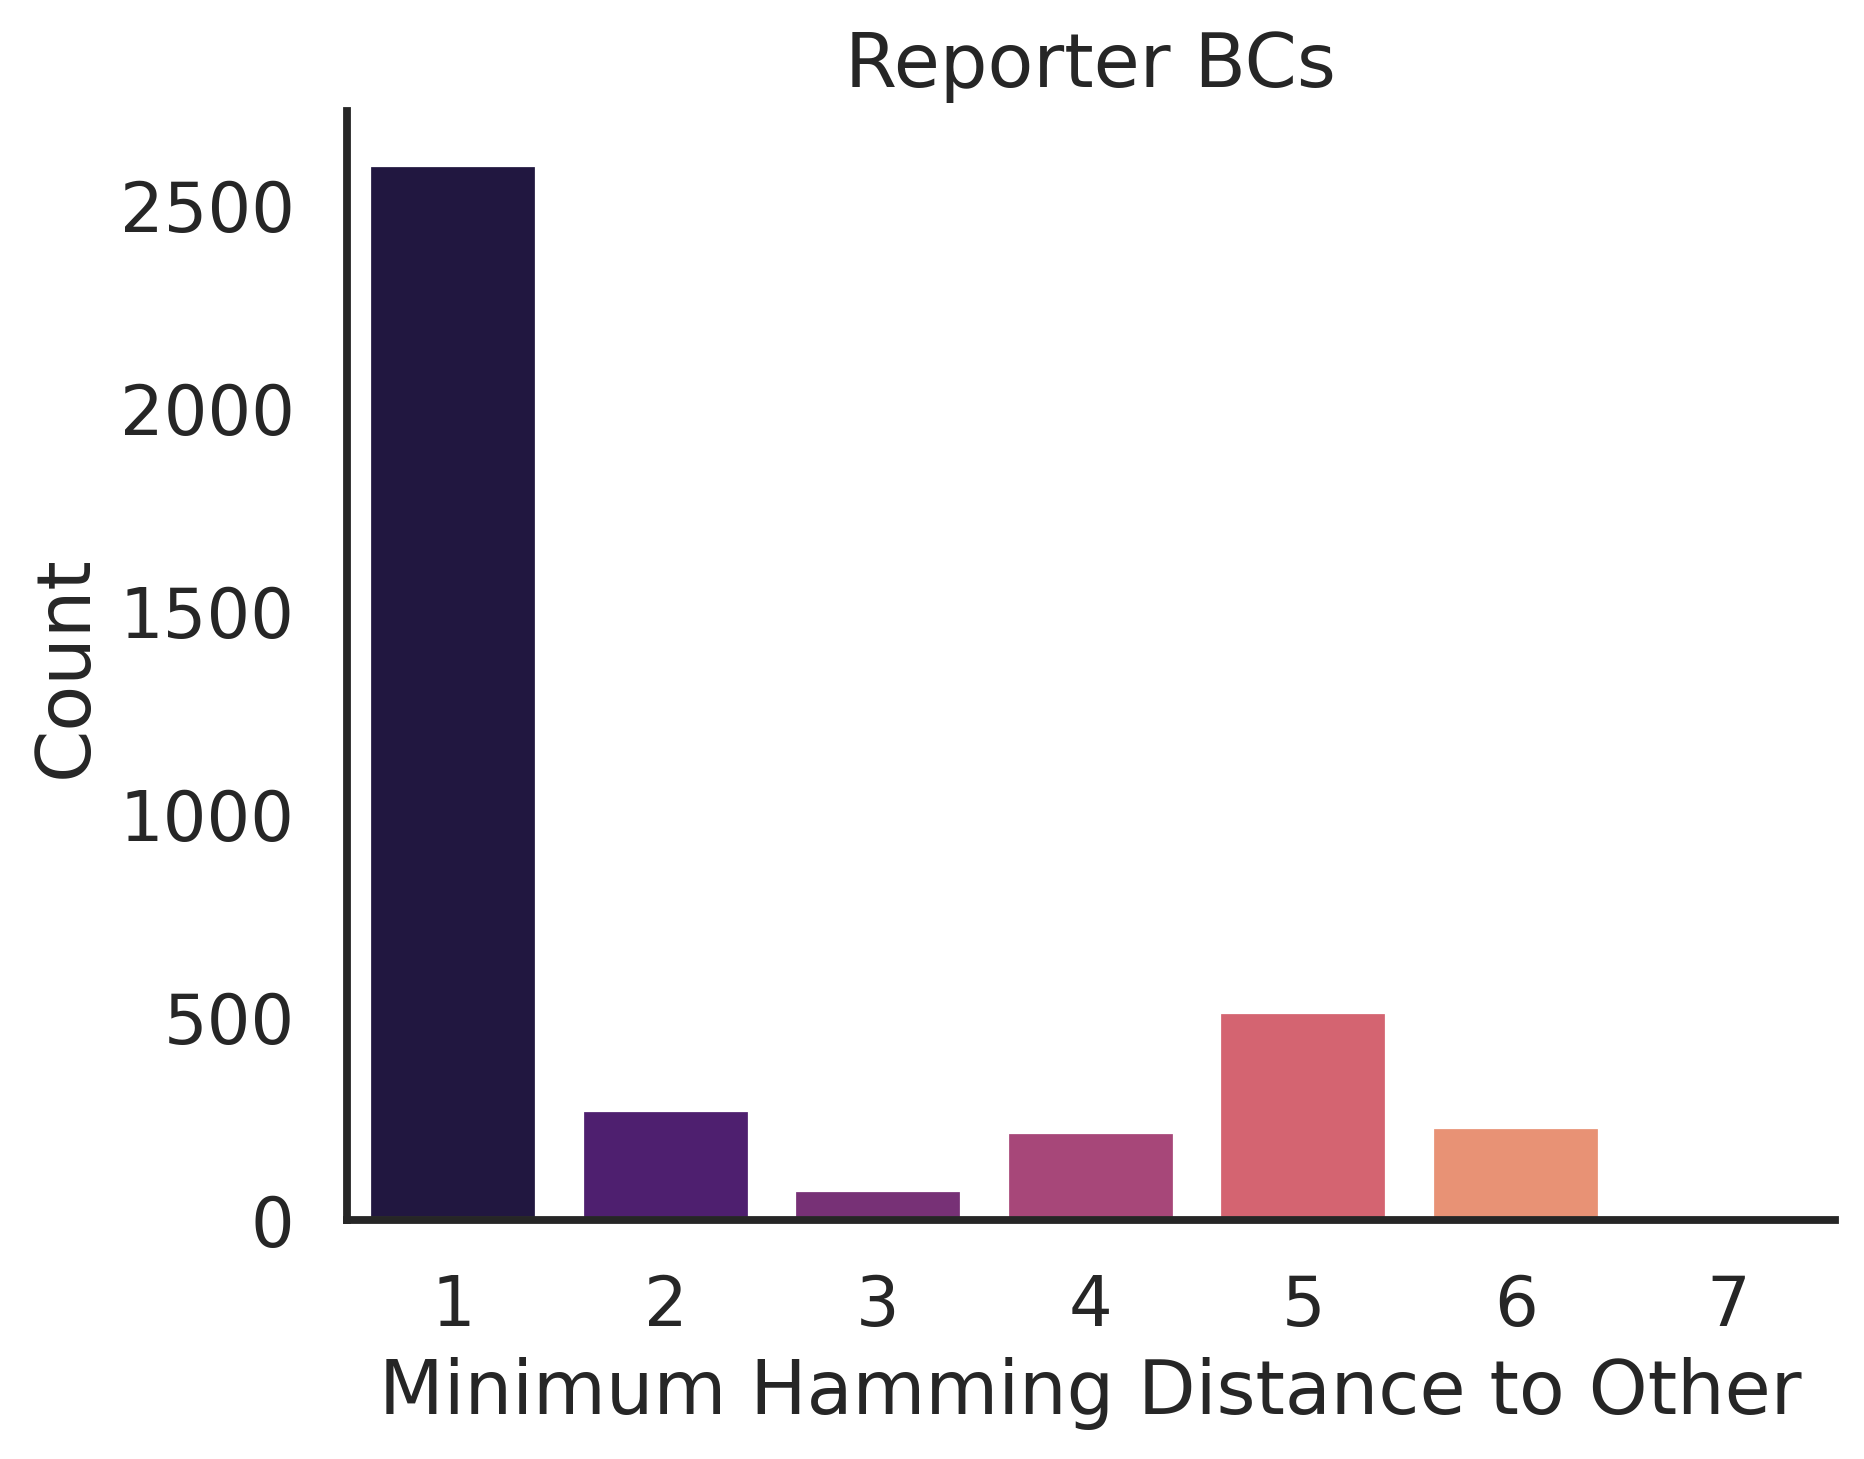

In [61]:
import matplotlib.pyplot as plt
plt.figure(dpi = 300)
sns.set_context('talk')
sns.barplot(pd.DataFrame(RTBC_dist["min_distance_to_other"].value_counts()).reset_index(), x = "min_distance_to_other", y = 'count', palette = 'magma')
sns.despine()
plt.title("Reporter BCs")
plt.ylabel("Count")
plt.xlabel("Minimum Hamming Distance to Other")

In [64]:
# What is the distance between RP BCs?
initial_AD_qual = initial[initial["AD_qual"] == True]
initial_AD_qual_counts = pd.DataFrame(initial_AD_qual["AD"].value_counts()).reset_index()
initial_AD_qual_counts = initial_AD_qual_counts["AD"]
AD_dist = nearest_neighbors_parallel_df(list(initial_AD_qual_counts))
AD_dist

100%|██████████| 6339/6339 [05:11<00:00, 20.38it/s]


,sequence,min_distance_to_other,nearest_neighbor
0,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,1,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...
1,ACCGACTTCATCGACGAGGAGGTGCTGATGAGCCTGGTGATCGAGA...,1,ACCGACTTCATCGACGAGGAGGTGCTGATGAGCCTGGTGATCGAGA...
2,ACCGACTTCATCGACGAGGAGGTGTTCATGAGCTTCGTGATCGAGA...,1,ACCGACTTCATCGCCGAGGAGGTGTTCATGAGCTTCGTGATCGAGA...
3,AGCACCGCTCCTCCCACCGACGTGAGCCTGGGCGACGAGCTGCACC...,1,AGCACCGCTCCTCCCACCGACGTGAGCCTGGGCGACGAGCTGCACC...
4,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,1,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...
...,...,...,...
6334,AGCACCGCTCCTCCCACCGACGTGAGCCTGGGCGACGAGCTGCACC...,2,AGCACCGCTCCTCCCACCGACGTGAGCCTGGGCGACGAGCTGCACC...
6335,GCCCAGGACCTGGCCGCCGCCACCTTCCAGCTGTGCATTCCCTTCA...,4,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...
6336,CCCCAGGACCTGGCCGCCGCCACCTTCCAGGGCGCTCCCAGCGCCT...,1,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGGCGCTCCCAGCGCCT...
6337,CCCTTCAGCGCCTACAGCGCCCAGAGCCTGCAGCACATGTATCCCA...,4,CCCTTCAGCGCCTACAGCGCCCAGAGCCTGCAGCACATGTATCCCA...


Text(0.5, 0, 'Minimum Hamming Distance to Other')

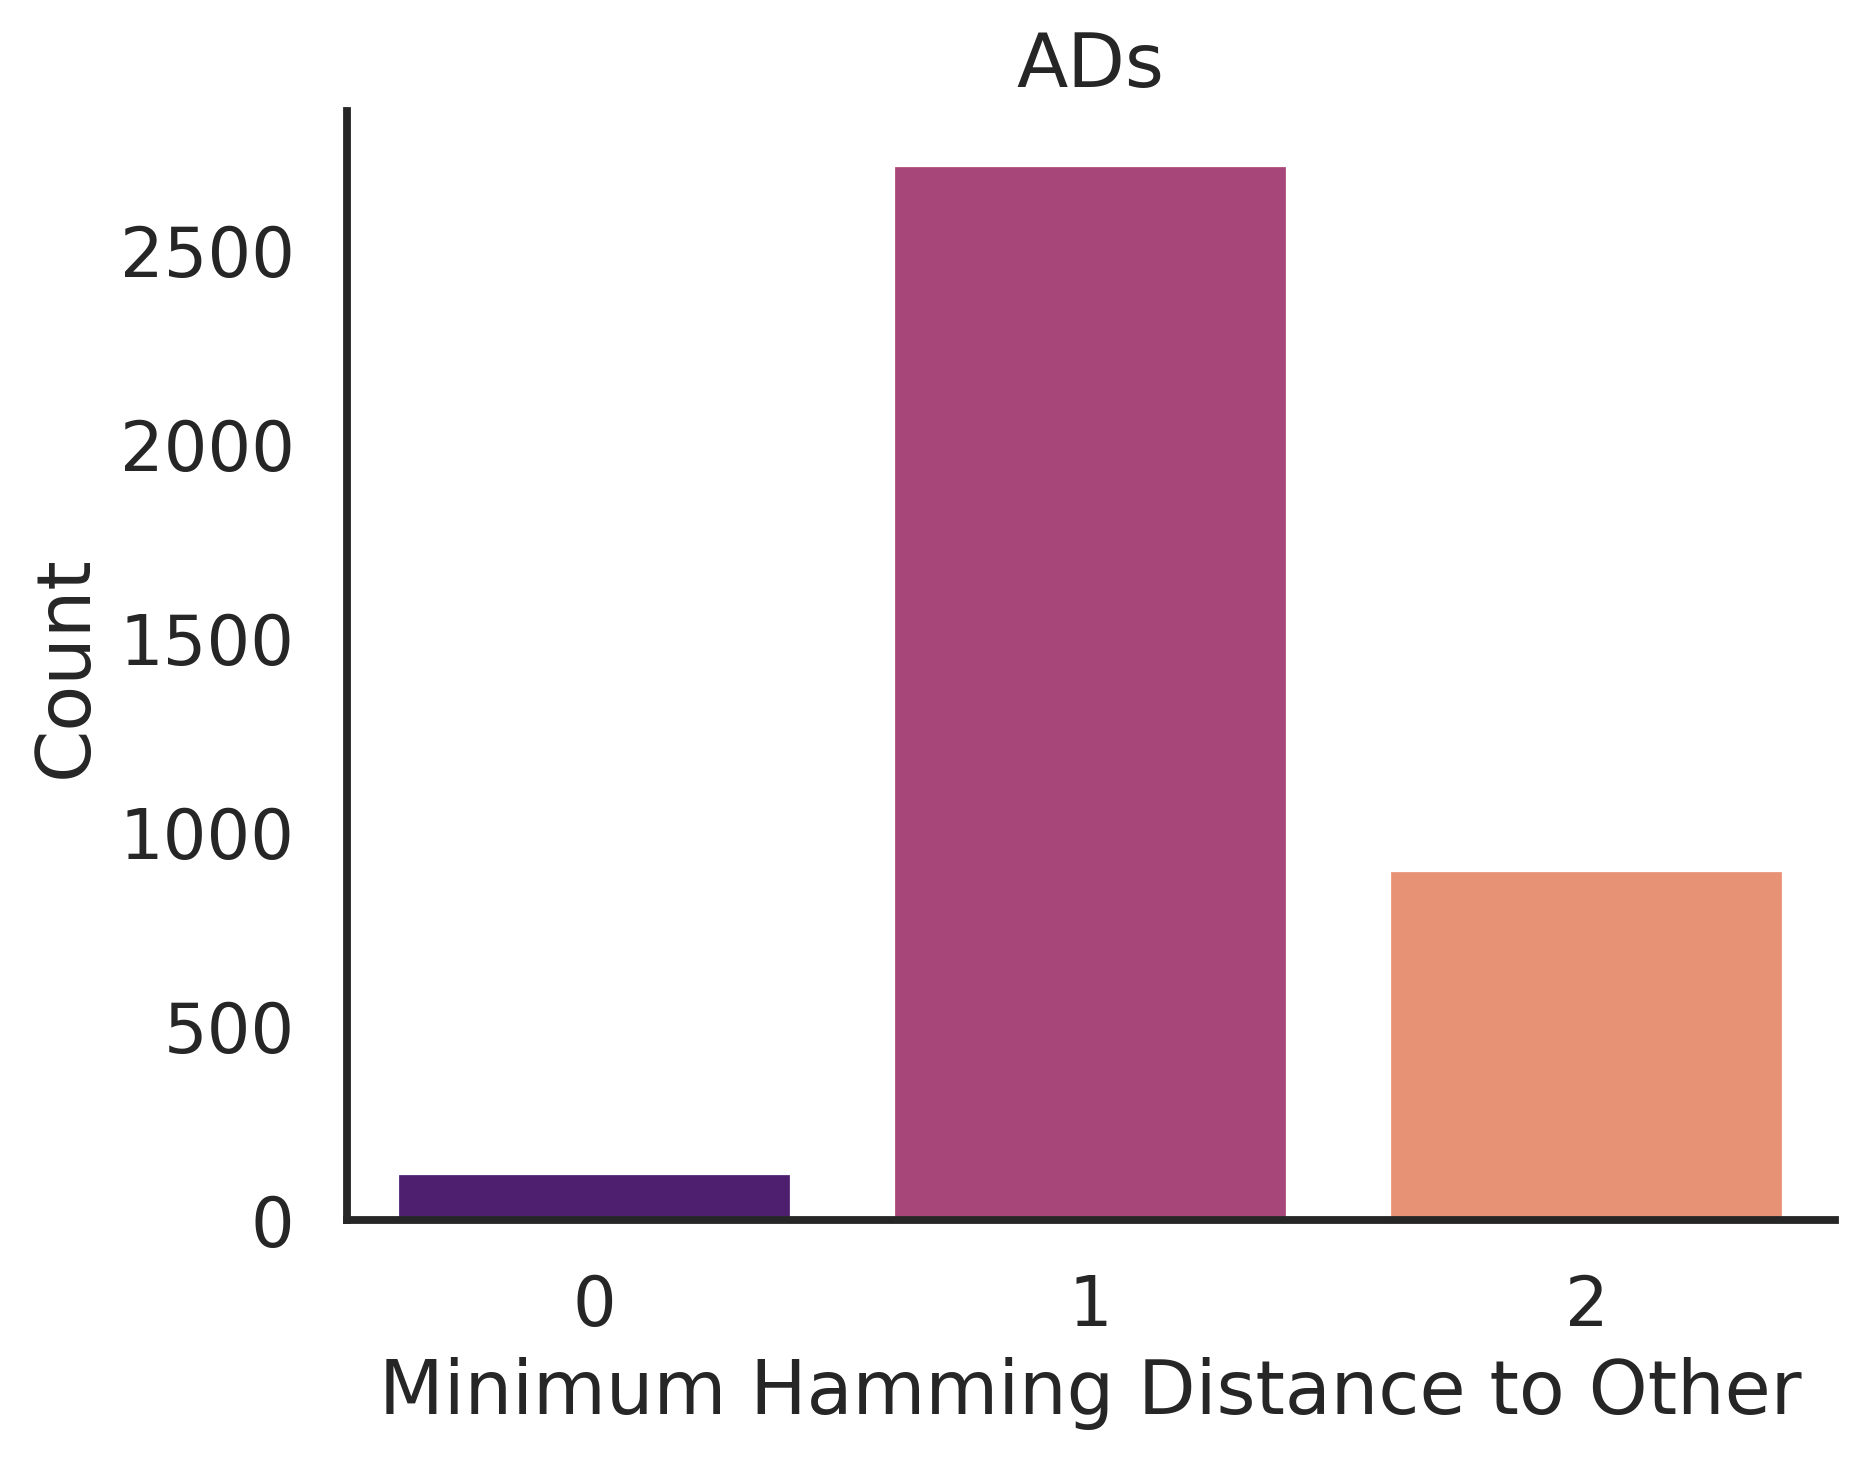

In [63]:
import matplotlib.pyplot as plt
plt.figure(dpi = 300)
sns.set_context('talk')
sns.barplot(pd.DataFrame(AD_dist["min_distance_to_other"].value_counts()).reset_index(), x = "min_distance_to_other", y = 'count', palette = 'magma')
sns.despine()
plt.title("ADs")
plt.ylabel("Count")
plt.xlabel("Minimum Hamming Distance to Other")

In [19]:
import networkx as nx
from collections import defaultdict
import random
from joblib import Parallel, delayed
from tqdm import tqdm
import pandas as pd

def hamming_distance(s1, s2):
    return sum(c1 != c2 for c1, c2 in zip(s1, s2))

def build_graph_parallel(umi_counts, threshold=1, n_jobs=-1):
    """Build UMI graph in parallel using Hamming distance."""
    umis = list(umi_counts.keys())
    G = nx.Graph()
    for u in umis:
        G.add_node(u, count=umi_counts[u])

    def check_pair(i, j):
        if hamming_distance(umis[i], umis[j]) <= threshold:
            return (umis[i], umis[j])
        return None

    pairs = [(i, j) for i in range(len(umis)) for j in range(i+1, len(umis))]
    edges = Parallel(n_jobs=n_jobs)(
        delayed(check_pair)(i, j) for i, j in tqdm(pairs, desc="Computing edges")
    )
    for e in edges:
        if e is not None:
            G.add_edge(*e)
    return G

def adjacency_clustering_df(umi_counts, threshold=1, seed=None, n_jobs=-1):
    """Adjacency-based UMI clustering and return a DataFrame."""
    if seed is not None:
        random.seed(seed)

    G = build_graph_parallel(umi_counts, threshold=threshold, n_jobs=n_jobs)
    cluster_records = []

    for component in nx.connected_components(G):
        subgraph = G.subgraph(component).copy()
        visited = set()
        selected = []

        while len(visited) < len(subgraph):
            candidates = [n for n in subgraph.nodes if n not in visited]
            if not candidates:
                break
            max_count = max(subgraph.nodes[n]["count"] for n in candidates)
            top_nodes = [n for n in candidates if subgraph.nodes[n]["count"] == max_count]
            rep = random.choice(top_nodes)
            selected.append(rep)
            visited |= {rep} | set(subgraph.neighbors(rep))

        # Assign each UMI to its representative
        for node in component:
            if node in selected:
                rep = node
            else:
                neighbors = set(G.neighbors(node)) & set(selected)
                if not neighbors:
                    rep = max(selected, key=lambda x: umi_counts[x])
                else:
                    rep = max(neighbors, key=lambda x: umi_counts[x])

            cluster_records.append({
                "umi": node,
                "count": umi_counts[node],
                "rep_umi": rep
            })

    df = pd.DataFrame(cluster_records)
    return df


# Example usage
umi_counts = {
    "ACGT": 456,
    "TCGT": 12,
    "CCGT": 11,
    "AAAT": 90,
    "ACAG": 75,
    "ACAT": 72
}

df = adjacency_clustering_df(umi_counts, threshold=1, seed=42, n_jobs=-1)
df

Computing edges: 100%|██████████| 15/15 [00:00<00:00, 19394.13it/s]


,umi,count,rep_umi
0,ACGT,456,ACGT
1,TCGT,12,ACGT
2,ACAG,75,ACAG
3,ACAT,72,ACGT
4,AAAT,90,AAAT
5,CCGT,11,ACGT


In [20]:
ADBC_counts = dict(zip(list(initial_ADBC2_qual_counts["ADBC2"]), 
                                         list(initial_ADBC2_qual_counts["count"])))

ADBC_cluster_df = adjacency_clustering_df(ADBC_counts, threshold=1, seed=42, n_jobs=-1)
ADBC_cluster_df

Computing edges: 100%|██████████| 1340703/1340703 [00:05<00:00, 236754.12it/s]


,umi,count,rep_umi
0,ATAAAG,20,ATAAAA
1,GGCGAA,18,GTCGAA
2,ATTGCC,43,ATTGAC
3,ACTGGT,7,GCTGGT
4,GTTTGC,18,TTTTGC
...,...,...,...
1633,TTACGT,27,TGACGT
1634,AAGAAA,94,AACAAA
1635,AGTGAA,6,AGTAAA
1636,CCGCTA,84,CCGCTA


In [21]:
ADBC_cluster_df["rep_umi"].value_counts()

rep_umi
AAATAT    17
AACAAA    17
CATGAA    15
ATTATT    14
ACAAGA    14
          ..
CTCATG     1
CCCTAC     1
GACTGC     1
TCCGAA     1
GCCTAT     1
Name: count, Length: 418, dtype: int64

In [22]:
ADBC_cluster_df[ADBC_cluster_df["rep_umi"] == "ATTATT"]

,umi,count,rep_umi
158,AATATT,102,ATTATT
202,ATAATT,19,ATTATT
315,CTTATT,14,ATTATT
329,ATTTTT,39,ATTATT
619,TTTATT,122,ATTATT
1055,ATTATG,18,ATTATT
1093,ATTATT,171,ATTATT
1118,ATTATC,37,ATTATT
1256,ATTCTT,59,ATTATT
1269,ATGATT,106,ATTATT


In [23]:
designed_qual = initial[initial["ADBC2_qual"] & initial["HawkBCs_qual"] & initial["RTBC_qual"] & initial["AD_qual"] & initial["Designed"]]
designed_qual

,ADBC2,ADBC2_qual,HawkBCs,HawkBCs_qual,RTBC,RTBC_qual,AD,AD_qual,Designed
9,CGATCC,True,CCACATCAT,True,GTAAAGTAGTAAATAC,True,AGCATGGACGAGAGCGGCCTGCCTCAGCTGACCAGCTACGACTGCG...,True,1
10,ACAGAC,True,ACAAGCGTT,True,CGATAATTTAGAATGT,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1
11,GAATTG,True,AACCTACGC,True,TAGCGTATTGAGCGAA,True,GCCCAGGACCTGAGCAGCCTGACCTTCCAGGCCGGCATTCCCTTCA...,True,1
12,ACCAGA,True,ACATTGCCG,True,AGAATTTGTTCGTCTG,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGAGCAGCGGCGCCTACT...,True,1
14,GCTTGC,True,AAGGATCTG,True,TCTAATAGTGGATCGT,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1
...,...,...,...,...,...,...,...,...,...
77529,CAATCA,True,CCAGAAGAT,True,ATGAACAAGCTCGGCA,True,GAGGAGCCTCAGAGCGATCCCAGCGTGGAGCCTCCTCTGAGCCAGG...,True,1
77530,GGGCGA,True,CCATCGACA,True,TAGCTAGAGTAAATTT,True,GACTCTCCCGGACCCGGCGCCACACCTCACGACAGCGCTCCCTACG...,True,1
77531,TGATCC,True,CCGTGTTGT,True,TGGTACGTAAATCTAC,True,ACCTTCAGCGACCTGTGGAAGCTGCTGCCCGAGAACAACGTGCTGT...,True,1
77533,TGAACC,True,ATCAGGACC,True,ACATATAAAAAGATAT,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCG...,True,1


In [24]:
designed_qual[designed_qual["ADBC2"].isin(ADBC_cluster_df[ADBC_cluster_df["rep_umi"] == "ATTATT"]["umi"])]#["AD"].value_counts()

,ADBC2,ADBC2_qual,HawkBCs,HawkBCs_qual,RTBC,RTBC_qual,AD,AD_qual,Designed
205,ATTCTT,True,CATACGATC,True,ATGTTTGTCTTGTACA,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1
256,ATTAAT,True,CAGTGAAGC,True,GTAATCTTGCCGTTGC,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1
309,ATAATT,True,ACGCAATCC,True,TGCTGAACACGCGAGC,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1
410,AATATT,True,AGAACACTC,True,GCTTCTAAAAGTAATC,True,GCCCAGGACGCCGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1
534,ATTTTT,True,AGCACAGGA,True,ACGCGAAGCGAAAGAT,True,TTCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1
...,...,...,...,...,...,...,...,...,...
77014,ATTATT,True,CCGGAGAAT,True,CCGTTTCCATAAGTTT,True,ACCGACTTCATCGACGAGGAGGTGGCCATGAGCGCCGTGATCGAGA...,True,1
77291,ATTATT,True,CCGGAGAAT,True,CCGTTTCCATAAGTTT,True,ACCGACTTCATCGACGAGGAGGTGGCCATGAGCGCCGTGATCGAGA...,True,1
77371,ATTCTT,True,CATACGATC,True,ATGTTTGTCTTGTACA,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1
77394,ATGATT,True,CCGAACCAA,True,TACAAAAACTGGATGA,True,CCTCCCACCGACGTGAGCGCCGGCGACGAGGCCCACGCCGACGGCG...,True,1


In [25]:
initial_ADBC2_qual_counts[initial_ADBC2_qual_counts["ADBC2"] == "GTACAA"]

,ADBC2,count
0,GTACAA,432


In [26]:
ADBC_cluster_df["cluster"].value_counts()

KeyError: 'cluster'

In [ ]:
ADBC_cluster_df[ADBC_cluster_df["cluster"] == 428]

In [ ]:
sns.histplot(ADBC_cluster_df["cluster"].value_counts(), discrete = True)
sns.despine()

In [27]:
# What is the distance between Hawk BCs?
initial_Hawk_BCs_qual = initial[initial["HawkBCs_qual"] == True]
initial_Hawk_BCs_qual_unique = initial_Hawk_BCs_qual["HawkBCs"].drop_duplicates()
Hawk_BCs_dist = nearest_neighbors_parallel_df(list(initial_Hawk_BCs_qual_unique))
Hawk_BCs_dist

100%|██████████| 782/782 [00:00<00:00, 2862.22it/s]


,sequence,min_distance_to_other,nearest_neighbor
0,ACCAAGATC,1,ACCGAGATC
1,GCAAGTGGA,1,ACAAGTGGA
2,AGCAGTGTA,1,AGCGGTGTA
3,CAGTTACAC,1,CAGTTACGC
4,CCACATCAT,1,GCACATCAT
...,...,...,...
777,ACGCTACGA,2,ACGCTACTT
778,ACGCTTGCC,1,ACCCTTGCC
779,ATCAAGATC,1,ACCAAGATC
780,AGCACAGGC,1,AGCACAGGA


In [35]:
pd.DataFrame(Hawk_BCs_dist["min_distance_to_other"].value_counts()).reset_index()

,min_distance_to_other,count
0,1,688
1,2,78
2,3,16


Text(0.5, 0, 'Minimum Hamming Distance to Other')

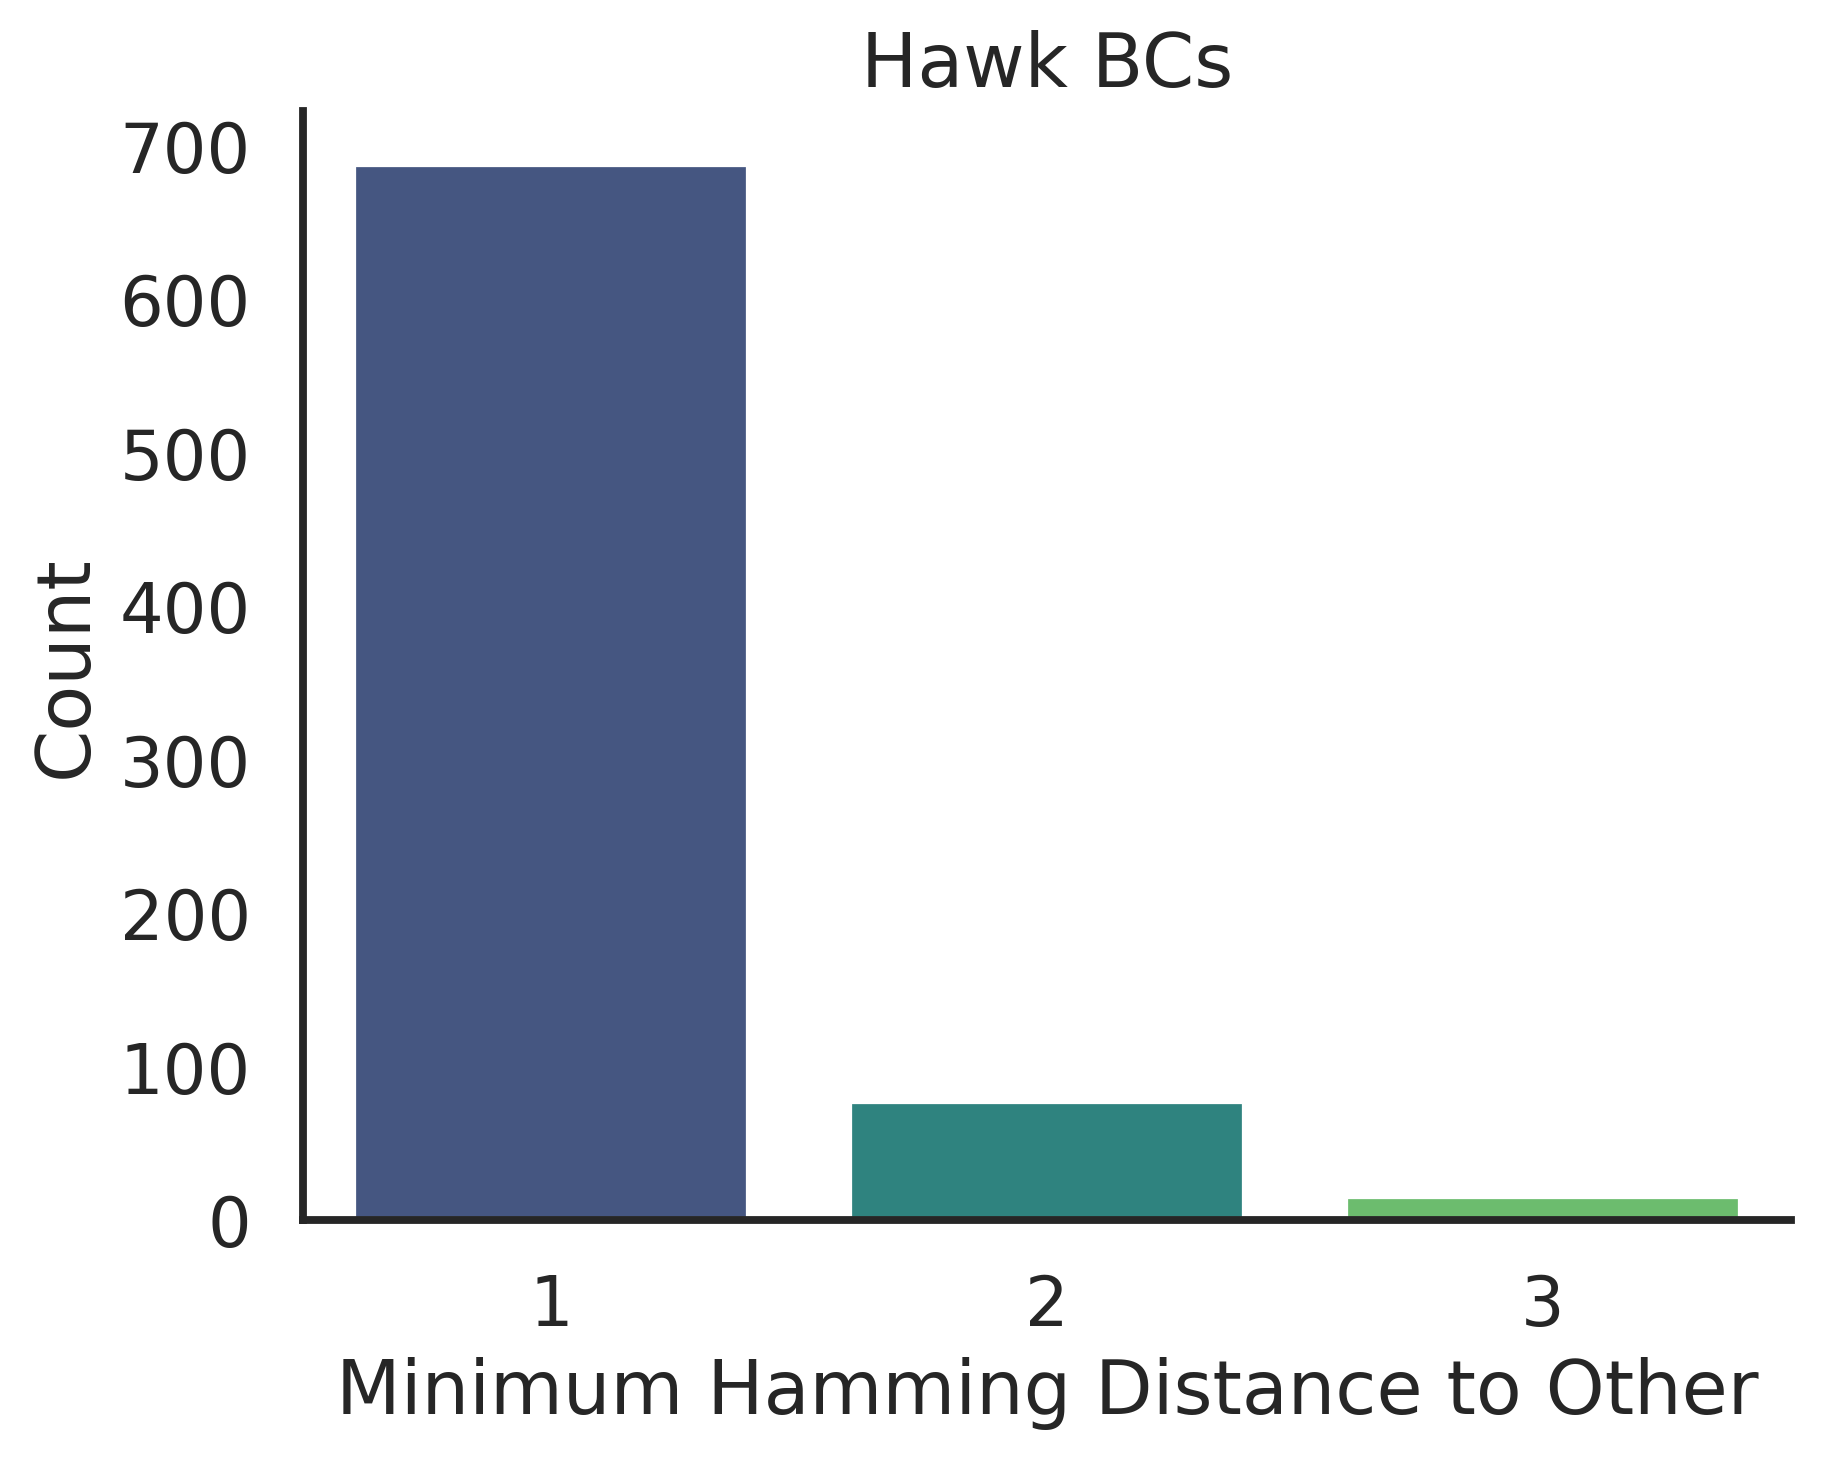

In [45]:
import matplotlib.pyplot as plt
plt.figure(dpi = 300)
sns.set_context('talk')
sns.barplot(pd.DataFrame(Hawk_BCs_dist["min_distance_to_other"].value_counts()).reset_index(), x = "min_distance_to_other", y = 'count', palette = 'viridis')
sns.despine()
plt.title("Hawk BCs")
plt.ylabel("Count")
plt.xlabel("Minimum Hamming Distance to Other")

In [46]:
# what about Hawk BC + AD BC2?
both_AD_bc = initial[initial["HawkBCs_qual"] & initial["ADBC2_qual"]]
both_AD_bc["Dual_ADBC"] = both_AD_bc["HawkBCs"] + both_AD_bc["ADBC2"]
# what about Hawk BC + AD BC2?
both_AD_bc_qual_counts = pd.DataFrame(both_AD_bc["Dual_ADBC"].value_counts()).reset_index()
both_AD_bc_qual_unique = both_AD_bc_qual_counts["Dual_ADBC"]
Dual_ADBC_dist = nearest_neighbors_parallel_df(list(both_AD_bc_qual_unique))
Dual_ADBC_dist

100%|██████████| 4510/4510 [00:22<00:00, 198.20it/s]


,sequence,min_distance_to_other,nearest_neighbor
0,CACCGATTGCCATAA,1,CACCAATTGCCATAA
1,CCATTAACGGTCAGC,1,CCATTAATGGTCAGC
2,ATCCGCTGTACCCCC,2,ATCCGCTGTAACCGC
3,AGATCGAAGACAAGA,3,AGATCGAAGGGAAGT
4,ATTGAACGGAAATAT,1,ATTGAACGCAAATAT
...,...,...,...
4505,CCATCGGTTGTTCAG,2,CCATCGGTTGTACAA
4506,CATACGATCTCGCAT,3,CATACGATCGCCGAT
4507,CACAAGGACTAACTA,2,CACAAGGACTGACCA
4508,ATGTTGAGGAGAGGA,2,ATGTTGAGGAAACGA


Text(0.5, 0, 'Minimum Hamming Distance to Other')

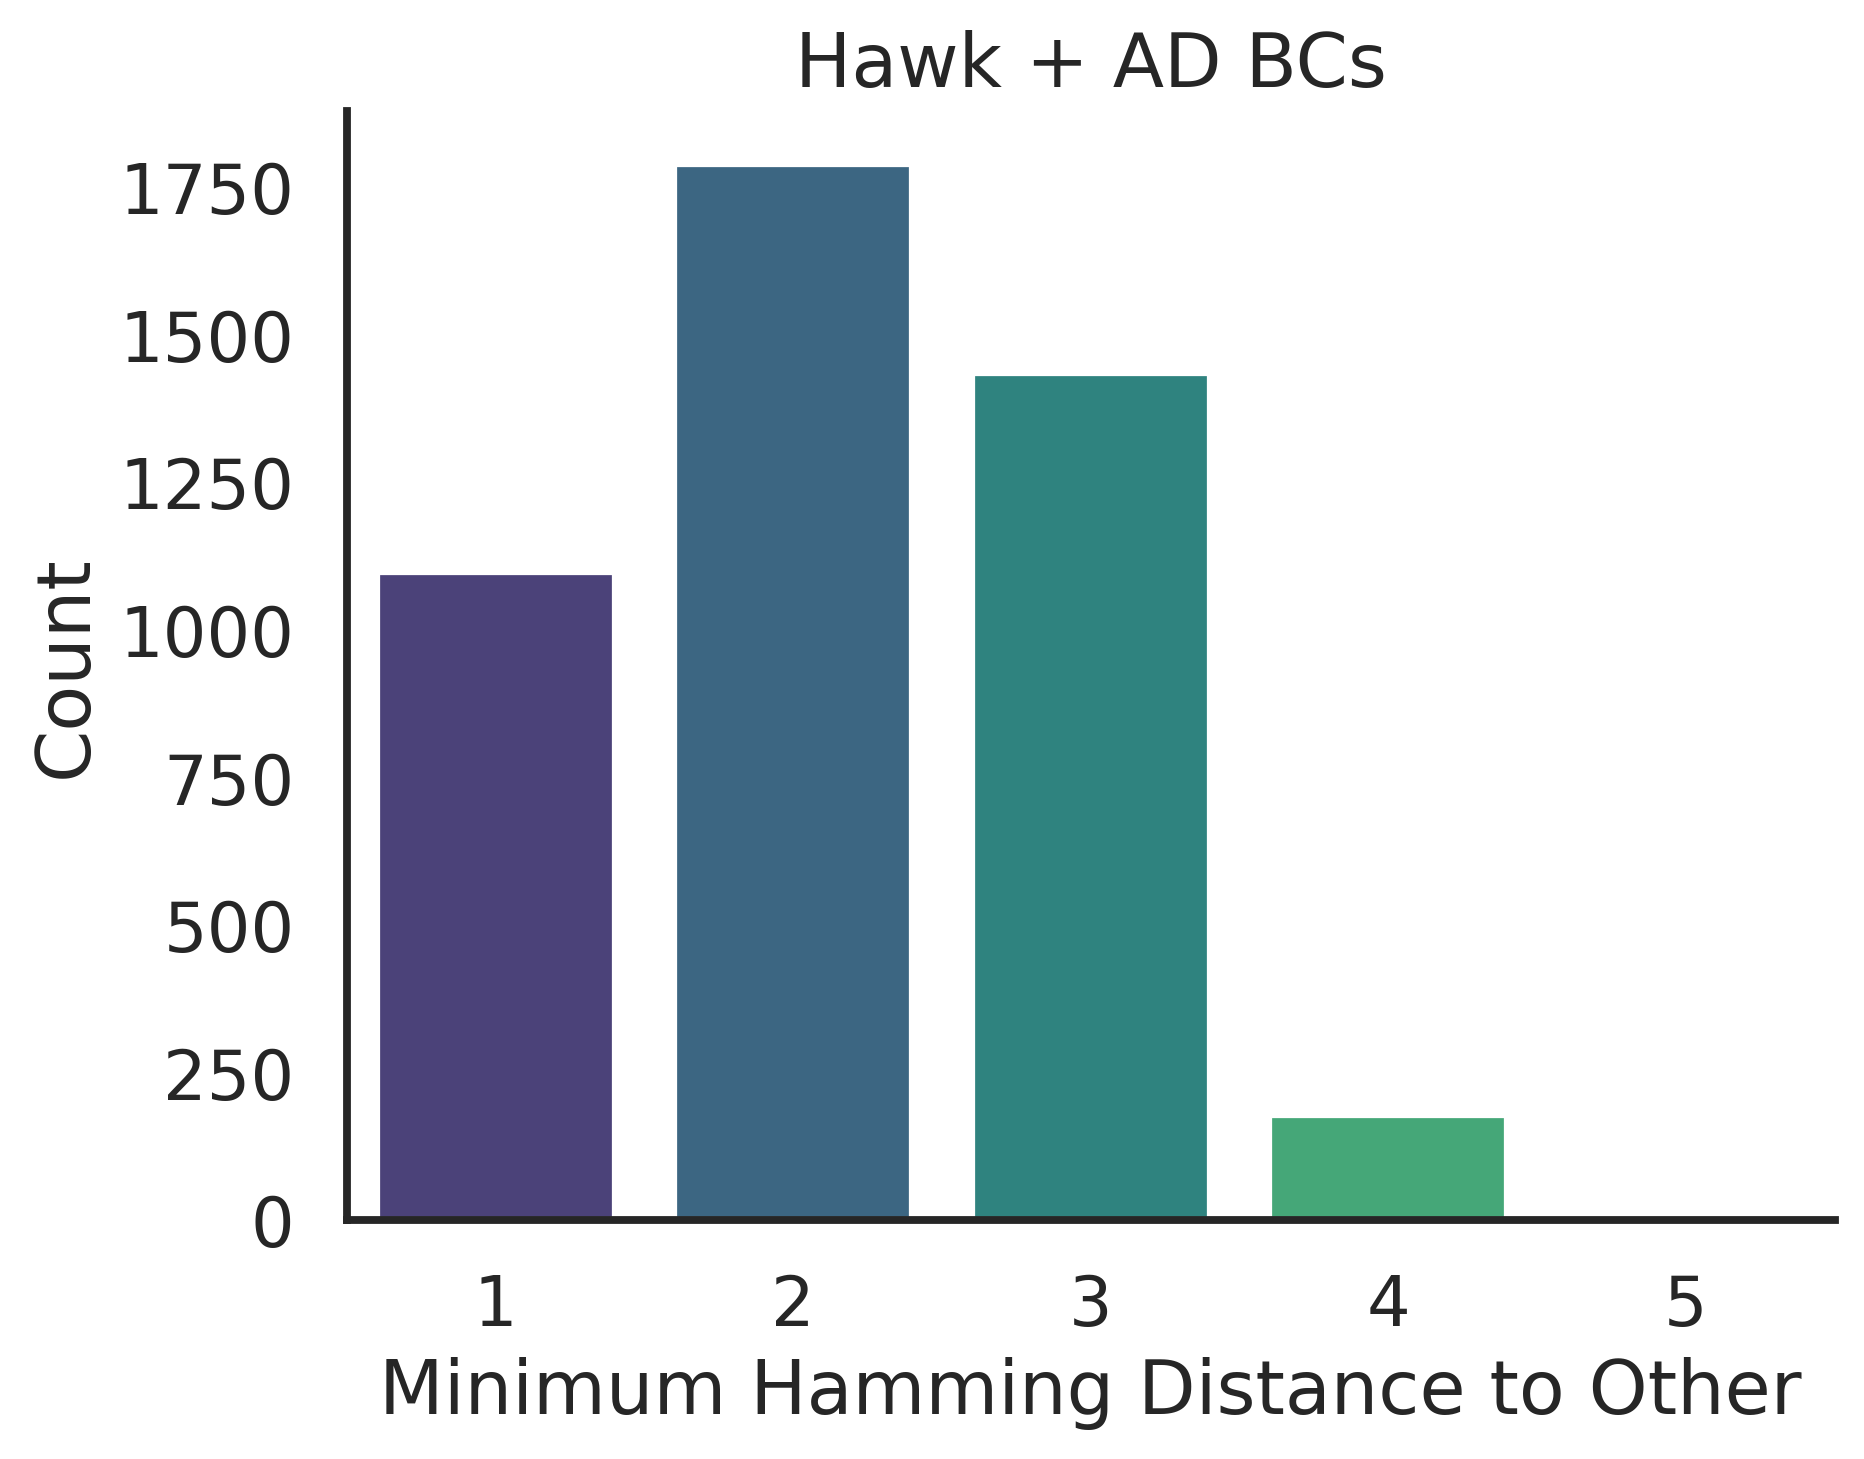

In [47]:
import matplotlib.pyplot as plt
plt.figure(dpi = 300)
sns.set_context('talk')
sns.barplot(pd.DataFrame(Dual_ADBC_dist["min_distance_to_other"].value_counts()).reset_index(), x = "min_distance_to_other", y = 'count', palette = 'viridis')
sns.despine()
plt.title("Hawk + AD BCs")
plt.ylabel("Count")
plt.xlabel("Minimum Hamming Distance to Other")

In [48]:
Dual_ADBC_dist["min_distance_to_other"].value_counts()

min_distance_to_other
2    1789
3    1436
1    1099
4     179
5       7
Name: count, dtype: int64

In [49]:
both_ADBC_counts = dict(zip(list(both_AD_bc_qual_counts["Dual_ADBC"]), 
                                         list(both_AD_bc_qual_counts["count"])))

both_ADBC_cluster_df = adjacency_clustering_df(both_ADBC_counts, threshold=1, seed=42, n_jobs=-1)
both_ADBC_cluster_df

Computing edges: 100%|██████████| 10167795/10167795 [00:44<00:00, 228096.29it/s]


,umi,count,rep_umi
0,CACCGATTGACATAA,1,CACCGATTGCCATAA
1,CACCGAGTGCCATAA,1,CACCGATTGCCATAA
2,CACCAATTGCCATAA,1,CACCGATTGCCATAA
3,CACCGATTACCATAA,1,CACCGATTGCCATAA
4,CACCGATTGCCATAA,341,CACCGATTGCCATAA
...,...,...,...
4505,ATACCGTCGATTTTG,1,ATACCGTCGATTTTG
4506,CCATCGGTTGTTCAG,1,CCATCGGTTGTTCAG
4507,CATACGATCTCGCAT,1,CATACGATCTCGCAT
4508,CACAAGGACTAACTA,1,CACAAGGACTAACTA


In [131]:
both_ADBC_cluster_df["rep_umi"].value_counts()

rep_umi
CCGATCTATAACAAA    7
CCAACACTAAGATCG    6
CACCGATTGCCATAA    6
ATAGCACACTATGTC    5
CCGATCTATGGAAAC    4
                  ..
ACTTGTTCCTCAGCA    1
AAGCTAAGGAGAGGA    1
ATATGCCTCAACTAT    1
AGTCCTCCTTCACAG    1
AGCACAGGAGGTCAA    1
Name: count, Length: 3930, dtype: int64

In [163]:
both_ADBC_cluster_df[both_ADBC_cluster_df["rep_umi"] == "CACCGATTGCCATAA"]

,umi,count,rep_umi
0,CACCGATCGCCATAA,1,CACCGATTGCCATAA
1,CACCGATTGCCATAA,341,CACCGATTGCCATAA
2,CACCGAGTGCCATAA,1,CACCGATTGCCATAA
3,CACCGATTGACATAA,1,CACCGATTGCCATAA
4,CACCGATTACCATAA,1,CACCGATTGCCATAA
5,CACCAATTGCCATAA,1,CACCGATTGCCATAA


In [146]:
designed_qual["Dual_ADBCs"] = designed_qual["HawkBCs"] + designed_qual["ADBC2"]
designed_qual

,ADBC2,ADBC2_qual,HawkBCs,HawkBCs_qual,RTBC,RTBC_qual,AD,AD_qual,Designed,Dual_ADBCs
9,CGATCC,True,CCACATCAT,True,GTAAAGTAGTAAATAC,True,AGCATGGACGAGAGCGGCCTGCCTCAGCTGACCAGCTACGACTGCG...,True,1,CCACATCATCGATCC
10,ACAGAC,True,ACAAGCGTT,True,CGATAATTTAGAATGT,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1,ACAAGCGTTACAGAC
11,GAATTG,True,AACCTACGC,True,TAGCGTATTGAGCGAA,True,GCCCAGGACCTGAGCAGCCTGACCTTCCAGGCCGGCATTCCCTTCA...,True,1,AACCTACGCGAATTG
12,ACCAGA,True,ACATTGCCG,True,AGAATTTGTTCGTCTG,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGAGCAGCGGCGCCTACT...,True,1,ACATTGCCGACCAGA
14,GCTTGC,True,AAGGATCTG,True,TCTAATAGTGGATCGT,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1,AAGGATCTGGCTTGC
...,...,...,...,...,...,...,...,...,...,...
77529,CAATCA,True,CCAGAAGAT,True,ATGAACAAGCTCGGCA,True,GAGGAGCCTCAGAGCGATCCCAGCGTGGAGCCTCCTCTGAGCCAGG...,True,1,CCAGAAGATCAATCA
77530,GGGCGA,True,CCATCGACA,True,TAGCTAGAGTAAATTT,True,GACTCTCCCGGACCCGGCGCCACACCTCACGACAGCGCTCCCTACG...,True,1,CCATCGACAGGGCGA
77531,TGATCC,True,CCGTGTTGT,True,TGGTACGTAAATCTAC,True,ACCTTCAGCGACCTGTGGAAGCTGCTGCCCGAGAACAACGTGCTGT...,True,1,CCGTGTTGTTGATCC
77533,TGAACC,True,ATCAGGACC,True,ACATATAAAAAGATAT,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCG...,True,1,ATCAGGACCTGAACC


In [158]:
dualBC_qual = initial[initial["ADBC2_qual"] & initial["HawkBCs_qual"] & initial["AD_qual"]]
dualBC_qual

,ADBC2,ADBC2_qual,HawkBCs,HawkBCs_qual,RTBC,RTBC_qual,AD,AD_qual,Designed,Dual_ADBCs
6,CTAGTA,True,AGCAGTGTA,True,None,False,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATCTATCCCA...,True,0,AGCAGTGTACTAGTA
9,CGATCC,True,CCACATCAT,True,GTAAAGTAGTAAATAC,True,AGCATGGACGAGAGCGGCCTGCCTCAGCTGACCAGCTACGACTGCG...,True,1,CCACATCATCGATCC
10,ACAGAC,True,ACAAGCGTT,True,CGATAATTTAGAATGT,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1,ACAAGCGTTACAGAC
11,GAATTG,True,AACCTACGC,True,TAGCGTATTGAGCGAA,True,GCCCAGGACCTGAGCAGCCTGACCTTCCAGGCCGGCATTCCCTTCA...,True,1,AACCTACGCGAATTG
12,ACCAGA,True,ACATTGCCG,True,AGAATTTGTTCGTCTG,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGAGCAGCGGCGCCTACT...,True,1,ACATTGCCGACCAGA
...,...,...,...,...,...,...,...,...,...,...
77530,GGGCGA,True,CCATCGACA,True,TAGCTAGAGTAAATTT,True,GACTCTCCCGGACCCGGCGCCACACCTCACGACAGCGCTCCCTACG...,True,1,CCATCGACAGGGCGA
77531,TGATCC,True,CCGTGTTGT,True,TGGTACGTAAATCTAC,True,ACCTTCAGCGACCTGTGGAAGCTGCTGCCCGAGAACAACGTGCTGT...,True,1,CCGTGTTGTTGATCC
77532,TATATC,True,ATAGCACAC,True,ATCTGACTACGCGGTA,True,GTCCAGGACGCCGCCGCCGCCACCGCCCAGGCCGGCATTCCCGCCA...,True,0,ATAGCACACTATATC
77533,TGAACC,True,ATCAGGACC,True,ACATATAAAAAGATAT,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCG...,True,1,ATCAGGACCTGAACC


In [166]:
designed_qual[designed_qual["Dual_ADBCs"].isin(both_ADBC_cluster_df[both_ADBC_cluster_df["rep_umi"] == "CACCGATTGCCATAA"]["umi"])][["AD", "Dual_ADBCs"]].value_counts()

AD                                                                                                                                                                  Dual_ADBCs     
GCCGGCGACCTGGCCGCCGCCACCTTCGGCGCCGGCATTCCCTTCAGCGCCTACAGCGCCGGCAGCCTGGGCCACATGGGCTACAACGCCGGCTACAGCAGCGCCAGCACACCCGGCTATCCCACCGCCCATCCTCTGGTGGGCGCCGGCGGCTGGACCTGG  CACCGATTGCCATAA    302
                                                                                                                                                                    CACCAATTGCCATAA      1
GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCGGCGCCTACGGCGCCCAGGGCCTGCAGCACATGCAGTACAACGCCCAGTACGGCGGCGCCGGCACACCTCAGTATCCCACCGCCCATCCTCTGGTGCAGGCCCAGCAGTGGACCTGG  CACCGATTGCCATAA      1
GCCGGCGACCTGGCCGCCGCCACCTTCGGCGCCGGCATTCCCTTCAGCGCCTACAGCGCCGGCAGCCTGGGCCACATGGGCTACAACGCCGGCTACAGCAGCGCCAGCACACCCGGCTATCCCACCGCCCATCCTCTGGTGGGCGCCGGCGGCTGGACCTGG  CACCGAGTGCCATAA      1
                                                                        

In [168]:
designed_qual[designed_qual["AD"] == "GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCGGCGCCTACGGCGCCCAGGGCCTGCAGCACATGCAGTACAACGCCCAGTACGGCGGCGCCGGCACACCTCAGTATCCCACCGCCCATCCTCTGGTGCAGGCCCAGCAGTGGACCTGG"]["Dual_ADBCs"].value_counts()

Dual_ADBCs
ATCAGGACCCTAATA    119
ATCAGGACCCTAACG     40
ATCAGGACCTGAACC     36
ATCAGGACCATGATG     34
ATCAGGACCAAGAAC     21
ATCAGGACCGTAAAA     20
ATCAGGACCGATTCC     20
ATCAGGACCACAGTG     17
ATCAGGACCGATATA     17
ATCAGGACCGATAGC     13
ATCAGGACCACTGGT      5
ATCAGGACCAGTCAC      3
AACTTCTGGCAGCCT      2
CACCGATTGCCATAA      1
AGAACACTCAATATT      1
ATCAGGACCGTACAA      1
AAGATTCCGAGAAAA      1
ATCAGGACCCCTACG      1
ATCAGGACCGTGACA      1
ATCAGGACCTGACCA      1
CAGCCTCAATTCGGT      1
ATCAGGACCACTGAG      1
ATTACGCTCACTTGC      1
AAGTCTCACCTAGAA      1
AGCAGTGTAAATTCA      1
AGATAACGCGGCACT      1
ACAAGCGTTTATATC      1
AGTGCCGAATTGAAT      1
ATCAGGACCGACTAG      1
ATCAGGACCCCCTAT      1
ACCTGGAACGTGGAC      1
ACATACTCCCTAGTA      1
AATCGACTCGAATAA      1
ACCAGGACCCTAATA      1
ATCAGGTCCCTAATA      1
ACACTAACCAAGCGA      1
ATCAGGACCCCGGAA      1
ATTCGGTTCCATTAT      1
AGCAGGACCCTAATA      1
ATATGCCTCTAAACG      1
ATGTTGAGGAACAAA      1
AGTGTAACCCGAAGA      1
CACTGACTATACGGA      1


In [231]:
# what about ADs?
ADs = initial[initial["AD_qual"]]
AD_qual_counts = pd.DataFrame(ADs["AD"].value_counts()).reset_index()
AD_qual_unique = AD_qual_counts["AD"]
# AD_dist = nearest_neighbors_parallel_df(list(AD_qual_unique))
# AD_dist

In [235]:
AD_counts = dict(zip(list(AD_qual_counts["AD"]), 
                                         list(AD_qual_counts["count"])))

AD_cluster_df = adjacency_clustering_df(AD_counts, threshold=1, seed=42, n_jobs=-1)
AD_cluster_df

In [177]:
AD_cluster_df["rep_umi"].value_counts()

rep_umi
GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCAGCGCCTACAGCGCCCAGAGCCTGCAGCACATGCAGTACAACGCCCAGTACAGCAGCGCCAGCACACCTCAGTATCCCACCGCCCATCCTCTGGTGCAGGCCCAGCAGTGGACCTGG    82
AGCACCGCTCCTCCCACCGACGTGAGCCTGGGCGACGAGCTGCACCTGGACGGCGAGGACGTGGCCATGGCCCACGCCGACGCCCTGGACGACTTCGACCTGGACATGCTGGGCGACGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGC    47
ACCGACTTCATCGACGAGGAGGTGCTGATGAGCCTGGTGATCGAGATGGGCCTGGACAGAATCAAGGAGCTGCCCGAGCTGTGGCTGGGCCAGAACGAGTTCGACTTCATGACCGACTTCGGCAGCGGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGC    42
ACCGACTTCATCGACGAGGAGGTGTTCATGAGCTTCGTGATCGAGATGGGCTTCGACAGAATCAAGGAGTTTCCCGAGTTCTGGTTCGGCCAGAACGAGTTCGACTTCATGACCGACGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGC    38
GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCGACGCCTACGACGCCCAGGACCTGCAGCACATGCAGTACAACGCCCAGTACGACGACGCCGACACACCTCAGTATCCCACCGCCCATCCTCTGGTGCAGGCCCAGCAGTGGACCTGG    37
                                                                                                                                                   

In [190]:
AD_cluster_df[AD_cluster_df["rep_umi"] == "GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCAGCGCCTACAGCGCCCAGAGCCTGCAGCACATGCAGTACAACGCCCAGTACAGCAGCGCCAGCACACCTCAGTATCCCACCGCCCATCCTCTGGTGCAGGCCCAGCAGTGGACCTGG"].sort_values(by = "count", ascending = False)

,umi,count,rep_umi
147,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,852,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...
348,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,324,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...
565,GCCCAGGCCCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,293,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...
152,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,282,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...
527,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,281,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...
...,...,...,...
123,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,1,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...
121,GCCCAGGACCTGGCCTCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,1,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...
117,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,1,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...
114,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,1,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...


In [191]:
test = designed_qual[designed_qual["AD"].isin(AD_cluster_df[AD_cluster_df["rep_umi"] == "GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCAGCGCCTACAGCGCCCAGAGCCTGCAGCACATGCAGTACAACGCCCAGTACAGCAGCGCCAGCACACCTCAGTATCCCACCGCCCATCCTCTGGTGCAGGCCCAGCAGTGGACCTGG"].sort_values(by = "count", ascending = False)["umi"])]
test["AD"].value_counts()

AD
GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCAGCGCCTACAGCGCCCAGAGCCTGCAGCACATGCAGTACAACGCCCAGTACAGCAGCGCCAGCACACCTCAGTATCCCACCGCCCATCCTCTGGTGCAGGCCCAGCAGTGGACCTGG    752
GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCAGCGCCTACAGCGCCCAGAGCCTGCAGCACATGCAGTACAACGCCCAGTACAGCAGCGCCAGCACACCTCAGTATCCCACCGCCCATCCTCTGGTGCTGGCCCAGCAGTGGACCTGG    307
GCCCAGGACCTGGCCGCCGCCACCTTCCTGGCCGGCATTCCCTTCAGCGCCTACAGCGCCCAGAGCCTGCAGCACATGCAGTACAACGCCCAGTACAGCAGCGCCAGCACACCTCAGTATCCCACCGCCCATCCTCTGGTGCAGGCCCAGCAGTGGACCTGG    266
GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCAGCGCCTACAGCGCCCAGAGCCTGCAGCACATGCAGTACAACGCCCTGTACAGCAGCGCCAGCACACCTCAGTATCCCACCGCCCATCCTCTGGTGCAGGCCCAGCAGTGGACCTGG    260
GCCCAGGCCCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCAGCGCCTACAGCGCCCAGAGCCTGCAGCACATGCAGTACAACGCCCAGTACAGCAGCGCCAGCACACCTCAGTATCCCACCGCCCATCCTCTGGTGCAGGCCCAGCAGTGGACCTGG    251
GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCAGCGCCTACAGCGCCCAGAGCCTGCAGCACATGCAGTACAACGCCCAGTACAGCAGCGCCAGCACACCTCAGTATCCCACCGGCCATCCTCTGGTGCAGGCC

In [180]:
initial[initial["AD"] == "GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCAGCGCCTACAGCGCCCAGAGCCTGCAGCACATGCAGTACAACGCCCAGTACAGCAGCGCCAGCACACCTCAGTATCCCACCGCCCATCCTCTGGTGCAGGCCCAGCAGTGGACCTGG"]

,ADBC2,ADBC2_qual,HawkBCs,HawkBCs_qual,RTBC,RTBC_qual,AD,AD_qual,Designed,Dual_ADBCs
44,ATTGAT,True,ACTTGTTCC,True,TAGCGAAAGTCATTTT,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1,ACTTGTTCCATTGAT
54,TATGCT,True,AACAACACC,True,AGGTAACTTAGTCTGC,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1,AACAACACCTATGCT
258,ATAAGT,True,AACAACACC,True,AGGCCACAGCACGATG,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1,AACAACACCATAAGT
290,TATGCT,True,AACAACACC,True,AGGTAACTTAGTCTGC,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1,AACAACACCTATGCT
307,AAATTC,True,CAGCGGTAT,True,ACTTATACTACATTTT,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1,CAGCGGTATAAATTC
...,...,...,...,...,...,...,...,...,...,...
77081,ATAAGT,True,AACAACACC,True,AGGCCACAGCACGATG,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1,AACAACACCATAAGT
77217,AGATCC,True,AATCGTGCC,True,AAAGCCATTCTCAAAT,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1,AATCGTGCCAGATCC
77385,CTATAC,True,AACAGCCGA,True,ATCTACAATTTCTCTT,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1,AACAGCCGACTATAC
77398,CAACAC,True,AACAACACC,True,CTTATTGATAGTTTAT,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1,AACAACACCCAACAC


In [51]:
import networkx as nx
from collections import defaultdict
import random
from joblib import Parallel, delayed
from tqdm import tqdm
import pandas as pd

def hamming_distance(s1, s2):
    return sum(c1 != c2 for c1, c2 in zip(s1, s2))

def build_graph_parallel(umi_counts, threshold=1, n_jobs=-1):
    """Build UMI graph in parallel using Hamming distance."""
    umis = list(umi_counts.keys())
    G = nx.Graph()
    for u in umis:
        G.add_node(u, count=umi_counts[u])

    def check_pair(i, j):
        if hamming_distance(umis[i], umis[j]) <= threshold:
            return (umis[i], umis[j])
        return None

    pairs = [(i, j) for i in range(len(umis)) for j in range(i+1, len(umis))]
    edges = Parallel(n_jobs=n_jobs)(
        delayed(check_pair)(i, j) for i, j in tqdm(pairs, desc="Computing edges")
    )
    for e in edges:
        if e is not None:
            G.add_edge(*e)
    return G

def directional_adjacency_clustering_df(umi_counts, threshold=1, seed=None, n_jobs=-1, ratio=0.1):
    """
    Adjacency clustering with directionality: only cluster a node into a higher-count node
    if its count < ratio * count of selected node.
    """
    if seed is not None:
        random.seed(seed)

    G = build_graph_parallel(umi_counts, threshold=threshold, n_jobs=n_jobs)
    cluster_records = []

    for component in nx.connected_components(G):
        subgraph = G.subgraph(component).copy()
        visited = set()
        selected = []

        while len(visited) < len(subgraph):
            candidates = [n for n in subgraph.nodes if n not in visited]
            if not candidates:
                break
            max_count = max(subgraph.nodes[n]["count"] for n in candidates)
            top_nodes = [n for n in candidates if subgraph.nodes[n]["count"] == max_count]
            rep = random.choice(top_nodes)
            selected.append(rep)
            visited |= {rep} | set(subgraph.neighbors(rep))

        # Assign each UMI to its representative based on abundance ratio
        for node in component:
            if node in selected:
                rep = node
            else:
                # Consider neighbors that are selected
                neighbors = set(G.neighbors(node)) & set(selected)
                # Only assign to neighbor if node count < ratio * neighbor count
                eligible_reps = [n for n in neighbors if umi_counts[node] < ratio * umi_counts[n]]
                if eligible_reps:
                    # choose highest count among eligible reps
                    rep = max(eligible_reps, key=lambda x: umi_counts[x])
                else:
                    # not eligible -> stays as its own representative
                    rep = node

            cluster_records.append({
                "umi": node,
                "count": umi_counts[node],
                "rep_umi": rep
            })

    df = pd.DataFrame(cluster_records)
    return df


# Example usage
umi_counts = {
    "ACGT": 456,
    "TCGT": 12,
    "CCGT": 11,
    "AAAT": 90,
    "ACAG": 75,
    "ACAT": 72
}

df = directional_adjacency_clustering_df(umi_counts, threshold=1, seed=42, n_jobs=-1, ratio=0.1)
df

Computing edges: 100%|██████████| 15/15 [00:00<00:00, 26875.08it/s]


,umi,count,rep_umi
0,ACGT,456,ACGT
1,TCGT,12,ACGT
2,ACAG,75,ACAG
3,ACAT,72,ACAT
4,AAAT,90,AAAT
5,CCGT,11,ACGT


In [52]:
len(AD_counts)

NameError: name 'AD_counts' is not defined

In [237]:
AD_directional_adjacency_clustering_df = directional_adjacency_clustering_df(AD_counts, threshold=1, seed=42, n_jobs=-1, ratio = 0.1)
AD_directional_adjacency_clustering_df


Computing edges: 100%|██████████| 20088291/20088291 [06:01<00:00, 55556.28it/s]


,umi,count,rep_umi
0,GCCCAGGACCTGGCCAGCGCCACCTTCCAGGCCGGCATTCCCTTCA...,1,GCCCAGGACCTGGCCAGCGCCACCTTCCAGGCCGGCATTCCCTTCA...
1,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,250,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...
2,TTCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,1,TTCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...
3,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,1,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...
4,GCCCAGGACCTGGCCGCCGCCACCTACCAGGCCGGCATTCCCTTCA...,1,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...
...,...,...,...
6334,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,1,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...
6335,GCCCAGTACCTGGCCGCCGCCACCTTCCAGGCCGGCATCGACTTCA...,1,GCCCAGTACCTGGCCGCCGCCACCTTCCAGGCCGGCATCGACTTCA...
6336,AGCACCGCTCCTCCCACCGACGTGAGCCTGGGCGACGAGCTGCACC...,1,AGCACCGCTCCTCCCACCGACGTGAGCCTGGGCGACGAGCTGCACC...
6337,GCCCAGGACCTGGCCGCCGCCACCTTCCAGCTGTGCATTCCCTTCA...,1,GCCCAGGACCTGGCCGCCGCCACCTTCCAGCTGTGCATTCCCTTCA...


In [321]:
AD_directional_adjacency_clustering_df.to_csv("../data/AD_directional_adjacency_clustering_df.csv")

In [323]:
AD_directional_adjacency_clustering_df["rep_AD"].value_counts()

rep_AD
GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCAGCGCCTACAGCGCCCAGAGCCTGCAGCACATGCAGTACAACGCCCAGTACAGCAGCGCCAGCACACCTCAGTATCCCACCGCCCATCCTCTGGTGCAGGCCCAGCAGTGGACCTGG    66
AGCACCGCTCCTCCCACCGACGTGAGCCTGGGCGACGAGCTGCACCTGGACGGCGAGGACGTGGCCATGGCCCACGCCGACGCCCTGGACGACTTCGACCTGGACATGCTGGGCGACGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGC    47
ACCGACTTCATCGACGAGGAGGTGCTGATGAGCCTGGTGATCGAGATGGGCCTGGACAGAATCAAGGAGCTGCCCGAGCTGTGGCTGGGCCAGAACGAGTTCGACTTCATGACCGACTTCGGCAGCGGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGC    42
ACCGACTTCATCGACGAGGAGGTGTTCATGAGCTTCGTGATCGAGATGGGCTTCGACAGAATCAAGGAGTTTCCCGAGTTCTGGTTCGGCCAGAACGAGTTCGACTTCATGACCGACGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGC    38
GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCGACGCCTACGACGCCCAGGACCTGCAGCACATGCAGTACAACGCCCAGTACGACGACGCCGACACACCTCAGTATCCCACCGCCCATCCTCTGGTGCAGGCCCAGCAGTGGACCTGG    37
                                                                                                                                                    

In [326]:
designed_rep_ADs = set(AD_directional_adjacency_clustering_df["rep_AD"]) & set(designed_qual["AD"])
len(designed_rep_ADs)

233

In [50]:
ADs_to_keep_df = AD_directional_adjacency_clustering_df[AD_directional_adjacency_clustering_df["rep_AD"].isin(designed_rep_ADs)]
ADs_to_keep_df

NameError: name 'designed_rep_ADs' is not defined

In [333]:
initial[initial["AD_qual"] & initial["Designed"]]

,ADBC2,ADBC2_qual,HawkBCs,HawkBCs_qual,RTBC,RTBC_qual,AD,AD_qual,Designed,Dual_ADBCs
8,None,False,CAGTTACAC,True,None,False,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1,NaN
9,CGATCC,True,CCACATCAT,True,GTAAAGTAGTAAATAC,True,AGCATGGACGAGAGCGGCCTGCCTCAGCTGACCAGCTACGACTGCG...,True,1,CCACATCATCGATCC
10,ACAGAC,True,ACAAGCGTT,True,CGATAATTTAGAATGT,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1,ACAAGCGTTACAGAC
11,GAATTG,True,AACCTACGC,True,TAGCGTATTGAGCGAA,True,GCCCAGGACCTGAGCAGCCTGACCTTCCAGGCCGGCATTCCCTTCA...,True,1,AACCTACGCGAATTG
12,ACCAGA,True,ACATTGCCG,True,AGAATTTGTTCGTCTG,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGAGCAGCGGCGCCTACT...,True,1,ACATTGCCGACCAGA
...,...,...,...,...,...,...,...,...,...,...
77529,CAATCA,True,CCAGAAGAT,True,ATGAACAAGCTCGGCA,True,GAGGAGCCTCAGAGCGATCCCAGCGTGGAGCCTCCTCTGAGCCAGG...,True,1,CCAGAAGATCAATCA
77530,GGGCGA,True,CCATCGACA,True,TAGCTAGAGTAAATTT,True,GACTCTCCCGGACCCGGCGCCACACCTCACGACAGCGCTCCCTACG...,True,1,CCATCGACAGGGCGA
77531,TGATCC,True,CCGTGTTGT,True,TGGTACGTAAATCTAC,True,ACCTTCAGCGACCTGTGGAAGCTGCTGCCCGAGAACAACGTGCTGT...,True,1,CCGTGTTGTTGATCC
77533,TGAACC,True,ATCAGGACC,True,ACATATAAAAAGATAT,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCG...,True,1,ATCAGGACCTGAACC


In [331]:
# Can keep roughly 3500 more reads with flexible matching vs using AD quality and designed check
initial[initial["AD"].isin(ADs_to_keep_df["AD_initial"])]

,ADBC2,ADBC2_qual,HawkBCs,HawkBCs_qual,RTBC,RTBC_qual,AD,AD_qual,Designed,Dual_ADBCs
6,CTAGTA,True,AGCAGTGTA,True,None,False,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATCTATCCCA...,True,0,AGCAGTGTACTAGTA
8,None,False,CAGTTACAC,True,None,False,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1,NaN
9,CGATCC,True,CCACATCAT,True,GTAAAGTAGTAAATAC,True,AGCATGGACGAGAGCGGCCTGCCTCAGCTGACCAGCTACGACTGCG...,True,1,CCACATCATCGATCC
10,ACAGAC,True,ACAAGCGTT,True,CGATAATTTAGAATGT,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1,ACAAGCGTTACAGAC
11,GAATTG,True,AACCTACGC,True,TAGCGTATTGAGCGAA,True,GCCCAGGACCTGAGCAGCCTGACCTTCCAGGCCGGCATTCCCTTCA...,True,1,AACCTACGCGAATTG
...,...,...,...,...,...,...,...,...,...,...
77529,CAATCA,True,CCAGAAGAT,True,ATGAACAAGCTCGGCA,True,GAGGAGCCTCAGAGCGATCCCAGCGTGGAGCCTCCTCTGAGCCAGG...,True,1,CCAGAAGATCAATCA
77530,GGGCGA,True,CCATCGACA,True,TAGCTAGAGTAAATTT,True,GACTCTCCCGGACCCGGCGCCACACCTCACGACAGCGCTCCCTACG...,True,1,CCATCGACAGGGCGA
77531,TGATCC,True,CCGTGTTGT,True,TGGTACGTAAATCTAC,True,ACCTTCAGCGACCTGTGGAAGCTGCTGCCCGAGAACAACGTGCTGT...,True,1,CCGTGTTGTTGATCC
77533,TGAACC,True,ATCAGGACC,True,ACATATAAAAAGATAT,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCG...,True,1,ATCAGGACCTGAACC


In [306]:
AD_directional_adjacency_clustering_df = AD_directional_adjacency_clustering_df.rename(columns = {"umi" : "AD_initial", "rep_umi" : "rep_AD"})
AD_directional_adjacency_clustering_df

,AD_initial,count,rep_AD
0,GCCCAGGACCTGGCCAGCGCCACCTTCCAGGCCGGCATTCCCTTCA...,1,GCCCAGGACCTGGCCAGCGCCACCTTCCAGGCCGGCATTCCCTTCA...
1,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,250,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...
2,TTCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,1,TTCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...
3,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,1,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...
4,GCCCAGGACCTGGCCGCCGCCACCTACCAGGCCGGCATTCCCTTCA...,1,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...
...,...,...,...
6334,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,1,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...
6335,GCCCAGTACCTGGCCGCCGCCACCTTCCAGGCCGGCATCGACTTCA...,1,GCCCAGTACCTGGCCGCCGCCACCTTCCAGGCCGGCATCGACTTCA...
6336,AGCACCGCTCCTCCCACCGACGTGAGCCTGGGCGACGAGCTGCACC...,1,AGCACCGCTCCTCCCACCGACGTGAGCCTGGGCGACGAGCTGCACC...
6337,GCCCAGGACCTGGCCGCCGCCACCTTCCAGCTGTGCATTCCCTTCA...,1,GCCCAGGACCTGGCCGCCGCCACCTTCCAGCTGTGCATTCCCTTCA...


In [316]:
# Does this approach merge any ADs which are in designed_qual?
designed_qual_AD_dir_adj_grouped = pd.merge(designed_qual, AD_directional_adjacency_clustering_df, left_on = "AD", right_on = "rep_AD")
designed_qual_AD_dir_adj_grouped

,ADBC2,ADBC2_qual,HawkBCs,HawkBCs_qual,RTBC,RTBC_qual,AD,AD_qual,Designed,Dual_ADBCs,AD_initial,count,rep_AD
0,CGATCC,True,CCACATCAT,True,GTAAAGTAGTAAATAC,True,AGCATGGACGAGAGCGGCCTGCCTCAGCTGACCAGCTACGACTGCG...,True,1,CCACATCATCGATCC,AGCATGGACGAGAGCGGCCTGCCTCAGCTGACCAGCTACGACTGCG...,1,AGCATGGACGAGAGCGGCCTGCCTCAGCTGACCAGCTACGACTGCG...
1,CGATCC,True,CCACATCAT,True,GTAAAGTAGTAAATAC,True,AGCATGGACGAGAGCGGCCTGCCTCAGCTGACCAGCTACGACTGCG...,True,1,CCACATCATCGATCC,AGCATGGACGAGAGGGGCCTGCCTCAGCTGACCAGCTACGACTGCG...,1,AGCATGGACGAGAGCGGCCTGCCTCAGCTGACCAGCTACGACTGCG...
2,CGATCC,True,CCACATCAT,True,GTAAAGTAGTAAATAC,True,AGCATGGACGAGAGCGGCCTGCCTCAGCTGACCAGCTACGACTGCG...,True,1,CCACATCATCGATCC,AGCATGGACGAGAGCGGCCTGCCTCAGCTGACCAGCTACGACTGCG...,176,AGCATGGACGAGAGCGGCCTGCCTCAGCTGACCAGCTACGACTGCG...
3,CGATCC,True,CCACATCAT,True,GTAAAGTAGTAAATAC,True,AGCATGGACGAGAGCGGCCTGCCTCAGCTGACCAGCTACGACTGCG...,True,1,CCACATCATCGATCC,AGCATGGACGAGAGCGGCCTGCCTCAGCTGACCAGCTACGACTGCG...,2,AGCATGGACGAGAGCGGCCTGCCTCAGCTGACCAGCTACGACTGCG...
4,CGATCC,True,CCACATCAT,True,GTAAAGTAGTAAATAC,True,AGCATGGACGAGAGCGGCCTGCCTCAGCTGACCAGCTACGACTGCG...,True,1,CCACATCATCGATCC,AGCATGGACGAGAGCGGCCTGCCTTAGCTGACCAGCTACGACTGCG...,1,AGCATGGACGAGAGCGGCCTGCCTCAGCTGACCAGCTACGACTGCG...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
891598,ACTAAC,True,AACGTCACT,True,GTGTAACACATTCTAG,True,TTCGCCGACGCCACCCAGGCCGCCCTGCAGGCCGGCATTCCCTTCA...,True,1,AACGTCACTACTAAC,TTCGCCGACGCCACCCAGGCCGCCCTGCAGGCCGGCATTCCCTTCA...,1,TTCGCCGACGCCACCCAGGCCGCCCTGCAGGCCGGCATTCCCTTCA...
891599,ACTAAC,True,AACGTCACT,True,GTGTAACACATTCTAG,True,TTCGCCGACGCCACCCAGGCCGCCCTGCAGGCCGGCATTCCCTTCA...,True,1,AACGTCACTACTAAC,TTCGCCGACGCCACCCAGGCCGCCCTGCAGGCCGGCATTCCCTTCA...,443,TTCGCCGACGCCACCCAGGCCGCCCTGCAGGCCGGCATTCCCTTCA...
891600,ACTAAC,True,AACGTCACT,True,GTGTAACACATTCTAG,True,TTCGCCGACGCCACCCAGGCCGCCCTGCAGGCCGGCATTCCCTTCA...,True,1,AACGTCACTACTAAC,TTCGCCGACGCCACCCACGCCGCCCTGCAGGCCGGCATTCCCTTCA...,1,TTCGCCGACGCCACCCAGGCCGCCCTGCAGGCCGGCATTCCCTTCA...
891601,ACTAAC,True,AACGTCACT,True,GTGTAACACATTCTAG,True,TTCGCCGACGCCACCCAGGCCGCCCTGCAGGCCGGCATTCCCTTCA...,True,1,AACGTCACTACTAAC,TTCGCCGACGCCACCCAGGCCGCCCTGCAGGCCGGCATTCCCTTCA...,1,TTCGCCGACGCCACCCAGGCCGCCCTGCAGGCCGGCATTCCCTTCA...


In [314]:
# Each representative UMI only maps to one AD in the designed qual group! THat's a good sanity check!
designed_qual_AD_dir_adj_grouped[["AD_initial","rep_AD"]].drop_duplicates()["rep_AD"].value_counts()

rep_AD
GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCAGCGCCTACAGCGCCCAGAGCCTGCAGCACATGCAGTACAACGCCCAGTACAGCAGCGCCAGCACACCTCAGTATCCCACCGCCCATCCTCTGGTGCAGGCCCAGCAGTGGACCTGG    66
AGCACCGCTCCTCCCACCGACGTGAGCCTGGGCGACGAGCTGCACCTGGACGGCGAGGACGTGGCCATGGCCCACGCCGACGCCCTGGACGACTTCGACCTGGACATGCTGGGCGACGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGC    47
ACCGACTTCATCGACGAGGAGGTGCTGATGAGCCTGGTGATCGAGATGGGCCTGGACAGAATCAAGGAGCTGCCCGAGCTGTGGCTGGGCCAGAACGAGTTCGACTTCATGACCGACTTCGGCAGCGGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGC    42
ACCGACTTCATCGACGAGGAGGTGTTCATGAGCTTCGTGATCGAGATGGGCTTCGACAGAATCAAGGAGTTTCCCGAGTTCTGGTTCGGCCAGAACGAGTTCGACTTCATGACCGACGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGC    38
GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCGACGCCTACGACGCCCAGGACCTGCAGCACATGCAGTACAACGCCCAGTACGACGACGCCGACACACCTCAGTATCCCACCGCCCATCCTCTGGTGCAGGCCCAGCAGTGGACCTGG    37
                                                                                                                                                    

In [258]:
len(designed_qual["AD"].unique())

233

In [320]:
initial

,ADBC2,ADBC2_qual,HawkBCs,HawkBCs_qual,RTBC,RTBC_qual,AD,AD_qual,Designed,Dual_ADBCs
0,None,False,None,False,None,False,None,False,0,NaN
1,None,False,ACCAAGATC,True,None,False,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,0,NaN
2,None,False,None,False,None,False,None,False,0,NaN
3,None,False,None,False,None,False,None,False,0,NaN
4,None,False,None,False,None,False,None,False,0,NaN
...,...,...,...,...,...,...,...,...,...,...
77530,GGGCGA,True,CCATCGACA,True,TAGCTAGAGTAAATTT,True,GACTCTCCCGGACCCGGCGCCACACCTCACGACAGCGCTCCCTACG...,True,1,CCATCGACAGGGCGA
77531,TGATCC,True,CCGTGTTGT,True,TGGTACGTAAATCTAC,True,ACCTTCAGCGACCTGTGGAAGCTGCTGCCCGAGAACAACGTGCTGT...,True,1,CCGTGTTGTTGATCC
77532,TATATC,True,ATAGCACAC,True,ATCTGACTACGCGGTA,True,GTCCAGGACGCCGCCGCCGCCACCGCCCAGGCCGGCATTCCCGCCA...,True,0,ATAGCACACTATATC
77533,TGAACC,True,ATCAGGACC,True,ACATATAAAAAGATAT,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCG...,True,1,ATCAGGACCTGAACC


In [319]:
# Does this approach merge any ADs which are in initial map?
#initial_AD_dir_adj_grouped = initial[initial["AD"].isin(#pd.merge(initial, AD_directional_adjacency_clustering_df, left_on = "AD", right_on = "rep_AD")
# Subset to ADs we care about - rep_umis are in 233
initial_AD_dir_adj_grouped_designed = initial_AD_dir_adj_grouped[initial_AD_dir_adj_grouped["rep_AD"].isin(designed_qual["AD"].unique())]
initial_AD_dir_adj_grouped_designed

# Seems like we can keep more rows in our initial map!

,ADBC2,ADBC2_qual,HawkBCs,HawkBCs_qual,RTBC,RTBC_qual,AD,AD_qual,Designed,Dual_ADBCs,AD_initial,count,rep_AD
3,None,False,CAGTTACAC,True,None,False,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1,NaN,TCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,1,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...
4,None,False,CAGTTACAC,True,None,False,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1,NaN,GCCCAGGACCTGGCAGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,1,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...
5,None,False,CAGTTACAC,True,None,False,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1,NaN,GCCCAGGACCTGTCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,1,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...
6,None,False,CAGTTACAC,True,None,False,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1,NaN,GCCCAGGACCTGGCCGCCGCCACCTTCCTGGCCGGCATTCCCTTCA...,2,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...
7,None,False,CAGTTACAC,True,None,False,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1,NaN,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,1,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1008103,ACTAAC,True,AACGTCACT,True,GTGTAACACATTCTAG,True,TTCGCCGACGCCACCCAGGCCGCCCTGCAGGCCGGCATTCCCTTCA...,True,1,AACGTCACTACTAAC,TTCGCCGACGCCACCCAGGCCGCCCTGCAGGCCGGCATTCCCTTCA...,1,TTCGCCGACGCCACCCAGGCCGCCCTGCAGGCCGGCATTCCCTTCA...
1008104,ACTAAC,True,AACGTCACT,True,GTGTAACACATTCTAG,True,TTCGCCGACGCCACCCAGGCCGCCCTGCAGGCCGGCATTCCCTTCA...,True,1,AACGTCACTACTAAC,TTCGCCGACGCCACCCAGGCCGCCCTGCAGGCCGGCATTCCCTTCA...,443,TTCGCCGACGCCACCCAGGCCGCCCTGCAGGCCGGCATTCCCTTCA...
1008105,ACTAAC,True,AACGTCACT,True,GTGTAACACATTCTAG,True,TTCGCCGACGCCACCCAGGCCGCCCTGCAGGCCGGCATTCCCTTCA...,True,1,AACGTCACTACTAAC,TTCGCCGACGCCACCCACGCCGCCCTGCAGGCCGGCATTCCCTTCA...,1,TTCGCCGACGCCACCCAGGCCGCCCTGCAGGCCGGCATTCCCTTCA...
1008106,ACTAAC,True,AACGTCACT,True,GTGTAACACATTCTAG,True,TTCGCCGACGCCACCCAGGCCGCCCTGCAGGCCGGCATTCCCTTCA...,True,1,AACGTCACTACTAAC,TTCGCCGACGCCACCCAGGCCGCCCTGCAGGCCGGCATTCCCTTCA...,1,TTCGCCGACGCCACCCAGGCCGCCCTGCAGGCCGGCATTCCCTTCA...


In [280]:
# Each representative UMI only maps to one AD in the designed qual group! THat's a good sanity check!
initial_AD_dir_adj_grouped_designed[["AD","rep_umi"]].drop_duplicates()["rep_umi"].value_counts()

rep_umi
GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCAGCGCCTACAGCGCCCAGAGCCTGCAGCACATGCAGTACAACGCCCAGTACAGCAGCGCCAGCACACCTCAGTATCCCACCGCCCATCCTCTGGTGCAGGCCCAGCAGTGGACCTGG    66
AGCACCGCTCCTCCCACCGACGTGAGCCTGGGCGACGAGCTGCACCTGGACGGCGAGGACGTGGCCATGGCCCACGCCGACGCCCTGGACGACTTCGACCTGGACATGCTGGGCGACGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGC    47
ACCGACTTCATCGACGAGGAGGTGCTGATGAGCCTGGTGATCGAGATGGGCCTGGACAGAATCAAGGAGCTGCCCGAGCTGTGGCTGGGCCAGAACGAGTTCGACTTCATGACCGACTTCGGCAGCGGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGC    42
ACCGACTTCATCGACGAGGAGGTGTTCATGAGCTTCGTGATCGAGATGGGCTTCGACAGAATCAAGGAGTTTCCCGAGTTCTGGTTCGGCCAGAACGAGTTCGACTTCATGACCGACGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGC    38
GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCGACGCCTACGACGCCCAGGACCTGCAGCACATGCAGTACAACGCCCAGTACGACGACGCCGACACACCTCAGTATCCCACCGCCCATCCTCTGGTGCAGGCCCAGCAGTGGACCTGG    37
                                                                                                                                                   

In [261]:
initial_AD_dir_adj_grouped[initial_AD_dir_adj_grouped["rep_umi"] == "GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCAGCGCCTACAGCGCCCAGAGCCTGCAGCACATGCAGTACAACGCCCAGTACAGCAGCGCCAGCACACCTCAGTATCCCACCGCCCATCCTCTGGTGCAGGCCCAGCAGTGGACCTGG"]["AD"].value_counts()

AD
GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCAGCGCCTACAGCGCCCAGAGCCTGCAGCACATGCAGTACAACGCCCAGTACAGCAGCGCCAGCACACCTCAGTATCCCACCGCCCATCCTCTGGTGCAGGCCCAGCAGTGGACCTGG    852
GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCAGCGCCTACAGCGCCCAGAGCCTGCAGCACATGCAGTACAACGCCCAGTACAGCAGCGCCAGCACACCTCAGTATCCCACCGCCGATCCTCTGGTGCAGGCCCAGCAGTGGACCTGG     31
GCCCAGGACCTGGCCGCCGCCGCCTTCCAGGCCGGCATTCCCTTCAGCGCCTACAGCGCCCAGAGCCTGCAGCACATGCAGTACAACGCCCAGTACAGCAGCGCCAGCACACCTCAGTATCCCACCGCCCATCCTCTGGTGCAGGCCCAGCAGTGGACCTGG      8
GCCCAGGACCTGGCCGCCGCCAGCTTCCAGGCCGGCATTCCCTTCAGCGCCTACAGCGCCCAGAGCCTGCAGCACATGCAGTACAACGCCCAGTACAGCAGCGCCAGCACACCTCAGTATCCCACCGCCCATCCTCTGGTGCAGGCCCAGCAGTGGACCTGG      4
GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCAGCGCCTACAGCGCCCAGAGCCTGCAGCACATGCAGTACAACGCCCAGTACAGCAGCGCCAGCACACCTCAGTATCCCACCGCCCATCCTCTGGTGCAGGCCCAGCAGTGGACCTGA      3
                                                                                                                                                   

In [266]:
initial_AD_dir_adj_grouped[initial_AD_dir_adj_grouped["rep_umi"] == "GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCAGCGCCTACAGCGCCCAGAGCCTGCAGCACATGCAGTACAACGCCCAGTACAGCAGCGCCAGCACACCTCAGTATCCCACCGCCCATCCTCTGGTGTTCGCCCAGCAGTGGACCTGG"]["AD"].value_counts()

AD
GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCAGCGCCTACAGCGCCCAGAGCCTGCAGCACATGCAGTACAACGCCCAGTACAGCAGCGCCAGCACACCTCAGTATCCCACCGCCCATCCTCTGGTGTTCGCCCAGCAGTGGACCTGG    614
GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCAGCGCCTACAGCGCCCAGAGCCTGCAGCACATGCAGTACAACGCCCAGTACAGCAGCGCCAGCACACCTCAGTATCCCACCGCCCATACTCTGGTGTTCGCCCAGCAGTGGACCTGG      2
GCCGAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCAGCGCCTACAGCGCCCAGAGCCTGCAGCACATGCAGTACAACGCCCAGTACAGCAGCGCCAGCACACCTCAGTATCCCACCGCCCATCCTCTGGTGTTCGCCCAGCAGTGGACCTGG      1
GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCAGCGCCTACAGCGCCCAGAGCCTGCAGCACATGCAGTACAACGCCCAGTACAGCAGCGCCAGCACACCTCAGTATCCCACCGCCCATCCCCTGGTGTTCGCCCAGCAGTGGACCTGG      1
GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCAGCGCCTACAGCGCCCAGAGCCTGCAGCACATGCAGTACAACGCCCAGTACAGCAGCGCCAGCACACCTCAGTATCCCACCGCCCATCCTCTGGTGTTCGCCCAGCAGAGGACCTGG      1
GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCAGCGCCTACAGCGCCCAGAGCCTGCAGCACATGCAGTACAACGCCCAGTACAGCAGCGCCAGCACACCTCAGTATCCCACCGCCCATCCTCTGGTGTTCGCC

In [282]:
# Apply to both AD BCs
both_ADBC_directional_adjacency_clustering_df = directional_adjacency_clustering_df(both_ADBC_counts, threshold=1, seed=42, n_jobs=-1, ratio = 0.1)
both_ADBC_directional_adjacency_clustering_df


Computing edges: 100%|██████████| 10167795/10167795 [00:52<00:00, 194251.71it/s]


,umi,count,rep_umi
0,CACCGATCGCCATAA,1,CACCGATTGCCATAA
1,CACCGATTGCCATAA,341,CACCGATTGCCATAA
2,CACCGAGTGCCATAA,1,CACCGATTGCCATAA
3,CACCGATTGACATAA,1,CACCGATTGCCATAA
4,CACCGATTACCATAA,1,CACCGATTGCCATAA
...,...,...,...
4505,ATACCGTCGATTTTG,1,ATACCGTCGATTTTG
4506,CCATCGGTTGTTCAG,1,CCATCGGTTGTTCAG
4507,CATACGATCTCGCAT,1,CATACGATCTCGCAT
4508,CACAAGGACTAACTA,1,CACAAGGACTAACTA


In [286]:
both_ADBC_directional_adjacency_clustering_df["rep_umi"].value_counts()

rep_umi
CCGATCTATAACAAA    7
CACCGATTGCCATAA    6
CCAACACTAAGATCG    6
ATAGCACACTATGTC    5
AATGTTCGGACGTCT    4
                  ..
CATCAGCGTTCGAGA    1
ACTTGTTCCTCAGCA    1
AAGCTAAGGAGAGGA    1
ATATGCCTCAACTAT    1
AACGGTGAATCGCAA    1
Name: count, Length: 4058, dtype: int64

In [295]:
both_ADBC_directional_adjacency_clustering_df[both_ADBC_directional_adjacency_clustering_df["rep_umi"] == "AATGTTCGGACGTCT"]

,umi,count,rep_umi
234,AATGTTCGGACGTCT,78,AATGTTCGGACGTCT
235,AAGGTTCGGACGTCT,1,AATGTTCGGACGTCT
236,AATGGTCGGACGTCT,1,AATGTTCGGACGTCT
237,AATGTTCGGACGACT,1,AATGTTCGGACGTCT


In [337]:
both_ADBC_directional_adjacency_clustering_df = both_ADBC_directional_adjacency_clustering_df.rename(columns = {"umi" : "BothAD_BC", "rep_umi" : "rep_BothAD_BC"})
both_ADBC_directional_adjacency_clustering_df

,BothAD_BC,count,rep_BothAD_BC
0,CACCGATCGCCATAA,1,CACCGATTGCCATAA
1,CACCGATTGCCATAA,341,CACCGATTGCCATAA
2,CACCGAGTGCCATAA,1,CACCGATTGCCATAA
3,CACCGATTGACATAA,1,CACCGATTGCCATAA
4,CACCGATTACCATAA,1,CACCGATTGCCATAA
...,...,...,...
4505,ATACCGTCGATTTTG,1,ATACCGTCGATTTTG
4506,CCATCGGTTGTTCAG,1,CCATCGGTTGTTCAG
4507,CATACGATCTCGCAT,1,CATACGATCTCGCAT
4508,CACAAGGACTAACTA,1,CACAAGGACTAACTA


In [338]:
both_ADBC_directional_adjacency_clustering_df.to_csv("../data/both_ADBC_directional_adjacency_clustering_df.csv")

In [53]:
both_ADBC_directional_adjacency_clustering_df = pd.read_csv("../data/both_ADBC_directional_adjacency_clustering_df.csv")
both_ADBC_directional_adjacency_clustering_df

,Unnamed: 0,BothAD_BC,count,rep_BothAD_BC
0,0,CACCGATCGCCATAA,1,CACCGATTGCCATAA
1,1,CACCGATTGCCATAA,341,CACCGATTGCCATAA
2,2,CACCGAGTGCCATAA,1,CACCGATTGCCATAA
3,3,CACCGATTGACATAA,1,CACCGATTGCCATAA
4,4,CACCGATTACCATAA,1,CACCGATTGCCATAA
...,...,...,...,...
4505,4505,ATACCGTCGATTTTG,1,ATACCGTCGATTTTG
4506,4506,CCATCGGTTGTTCAG,1,CCATCGGTTGTTCAG
4507,4507,CATACGATCTCGCAT,1,CATACGATCTCGCAT
4508,4508,CACAAGGACTAACTA,1,CACAAGGACTAACTA


In [57]:
both_ADBC_directional_adjacency_clustering_df["rep_BothAD_BC"].value_counts()

rep_BothAD_BC
CCGATCTATAACAAA    7
CACCGATTGCCATAA    6
CCAACACTAAGATCG    6
ATAGCACACTATGTC    5
AATGTTCGGACGTCT    4
                  ..
CATCAGCGTTCGAGA    1
ACTTGTTCCTCAGCA    1
AAGCTAAGGAGAGGA    1
ATATGCCTCAACTAT    1
AACGGTGAATCGCAA    1
Name: count, Length: 4058, dtype: int64

In [285]:
# What is the distance between RP BCs?
initial_RTBC_qual = initial[initial["RTBC_qual"] == True]
initial_RTBC_qual_count = pd.DataFrame(initial_RTBC_qual["RTBC"].value_counts().reset_index())
initial_RTBC_qual_unique = initial_RTBC_qual_count["RTBC"]
#RTBC_dist = nearest_neighbors_parallel_df(list(initial_RTBC_qual_unique))
#RTBC_dist

In [290]:
# Apply to RP BCs
RPBC_directional_adjacency_clustering_df = directional_adjacency_clustering_df(dict(zip(initial_RTBC_qual_count["RTBC"], initial_RTBC_qual_count["count"])), 
                                                                               threshold=1, 
                                                                               seed=42, 
                                                                               n_jobs=-1, 
                                                                               ratio = 0.1)
RPBC_directional_adjacency_clustering_df


Computing edges: 100%|██████████| 7693003/7693003 [00:39<00:00, 196318.46it/s]


,umi,count,rep_umi
0,CAGCGGTTAACAAGCG,1,CAGCGTTTAACAAGCG
1,CGGCGTTGAACAAGCG,1,CGGCGTTGAACAAGCG
2,CGGCGTTTAACAAGCG,1,CAGCGTTTAACAAGCG
3,CAGCGTTTAACAGGCG,3,CAGCGTTTAACAAGCG
4,AAGCGTTTAACAAGCG,1,CAGCGTTTAACAAGCG
...,...,...,...
3918,GCGATGGTAAGCACCA,1,GCGATGGTAAGCACCA
3919,ATGACAAAGAAAATAT,1,ATGACAAAGAAAATAT
3920,GTAGTTGAACAAGATA,1,GTAGTTGAACAAGATA
3921,GGGTTGTAAGAAAGCG,1,GGGTTGTAAGAAAGCG


In [291]:
RPBC_directional_adjacency_clustering_df["rep_umi"].value_counts()

rep_umi
TAAGCGGTTGGCCTTA    8
CACAAAACGTGGCGCC    8
CAATATTCCGGCGACT    8
TTCCTTGGGCAGGCGG    7
TTGCAGAATAGCTGCA    7
                   ..
GCGTCTTTGGTTACAC    1
GCTATTCGATGAAAAG    1
AGTTACGGAATCAGAA    1
AAATGTCATTTTAAGC    1
GATAGTGCGAAAGAAG    1
Name: count, Length: 2386, dtype: int64

In [335]:
RPBC_directional_adjacency_clustering_df = RPBC_directional_adjacency_clustering_df.rename(columns = {"umi" : "RPBC", "rep_umi" : "rep_RPBC"})
RPBC_directional_adjacency_clustering_df

,RPBC,count,rep_RPBC
0,CAGCGGTTAACAAGCG,1,CAGCGTTTAACAAGCG
1,CGGCGTTGAACAAGCG,1,CGGCGTTGAACAAGCG
2,CGGCGTTTAACAAGCG,1,CAGCGTTTAACAAGCG
3,CAGCGTTTAACAGGCG,3,CAGCGTTTAACAAGCG
4,AAGCGTTTAACAAGCG,1,CAGCGTTTAACAAGCG
...,...,...,...
3918,GCGATGGTAAGCACCA,1,GCGATGGTAAGCACCA
3919,ATGACAAAGAAAATAT,1,ATGACAAAGAAAATAT
3920,GTAGTTGAACAAGATA,1,GTAGTTGAACAAGATA
3921,GGGTTGTAAGAAAGCG,1,GGGTTGTAAGAAAGCG


In [336]:
RPBC_directional_adjacency_clustering_df.to_csv("../data/RPBC_directional_adjacency_clustering_df.csv")

In [292]:
RPBC_directional_adjacency_clustering_df[RPBC_directional_adjacency_clustering_df["rep_umi"] == "TAAGCGGTTGGCCTTA"]

,umi,count,rep_umi
201,TAAGCGGTTTGCCTTA,1,TAAGCGGTTGGCCTTA
202,TAAGCGGTGGGCCTTA,1,TAAGCGGTTGGCCTTA
203,TAAGCGGTTGGCGTTA,1,TAAGCGGTTGGCCTTA
204,TAAGCGGTTGGCCTTA,107,TAAGCGGTTGGCCTTA
205,AAAGCGGTTGGCCTTA,1,TAAGCGGTTGGCCTTA
206,TAAGCGGTTGGCCTTG,2,TAAGCGGTTGGCCTTA
207,TAAGCGGTTGGACTTA,1,TAAGCGGTTGGCCTTA
208,TAAGCGGTTGCCCTTA,1,TAAGCGGTTGGCCTTA


In [296]:
initial_AD_dir_adj_grouped

,ADBC2,ADBC2_qual,HawkBCs,HawkBCs_qual,RTBC,RTBC_qual,AD,AD_qual,Designed,Dual_ADBCs,umi,count,rep_umi
0,None,False,ACCAAGATC,True,None,False,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,0,NaN,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,1,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...
1,None,False,GCAAGTGGA,True,None,False,GCCCAGGACCTGGCCGCCGCCACCTTCCTGGCCGGCATTCCCTTCA...,True,0,NaN,GCCCAGGACCTGGCCGCCGCCACCTTCCTGGCCGGCATTCCCTTCA...,1,GCCCAGGACCTGGCCGCCGCCACCTTCCTGGCCGGCATTCCCTTCA...
2,CTAGTA,True,AGCAGTGTA,True,None,False,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATCTATCCCA...,True,0,AGCAGTGTACTAGTA,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATCTATCCCA...,1,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATCTATCCCA...
3,None,False,None,False,None,False,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,0,NaN,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,1,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...
4,None,False,CAGTTACAC,True,None,False,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,1,NaN,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,251,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67327,GGGCGA,True,CCATCGACA,True,TAGCTAGAGTAAATTT,True,GACTCTCCCGGACCCGGCGCCACACCTCACGACAGCGCTCCCTACG...,True,1,CCATCGACAGGGCGA,GACTCTCCCGGACCCGGCGCCACACCTCACGACAGCGCTCCCTACG...,269,GACTCTCCCGGACCCGGCGCCACACCTCACGACAGCGCTCCCTACG...
67328,TGATCC,True,CCGTGTTGT,True,TGGTACGTAAATCTAC,True,ACCTTCAGCGACCTGTGGAAGCTGCTGCCCGAGAACAACGTGCTGT...,True,1,CCGTGTTGTTGATCC,ACCTTCAGCGACCTGTGGAAGCTGCTGCCCGAGAACAACGTGCTGT...,555,ACCTTCAGCGACCTGTGGAAGCTGCTGCCCGAGAACAACGTGCTGT...
67329,TATATC,True,ATAGCACAC,True,ATCTGACTACGCGGTA,True,GTCCAGGACGCCGCCGCCGCCACCGCCCAGGCCGGCATTCCCGCCA...,True,0,ATAGCACACTATATC,GTCCAGGACGCCGCCGCCGCCACCGCCCAGGCCGGCATTCCCGCCA...,34,GTCCAGGACGCCGCCGCCGCCACCGCCCAGGCCGGCATTCCCGCCA...
67330,TGAACC,True,ATCAGGACC,True,ACATATAAAAAGATAT,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCG...,True,1,ATCAGGACCTGAACC,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCG...,415,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCG...


In [ ]:
pd.merge(initial_AD_dir_adj_grouped, 

In [ ]:
# Does this approach merge any ADs which are in initial map?
initial_AD_dir_adj_grouped = pd.merge(initial, AD_directional_adjacency_clustering_df, left_on = "AD", right_on = "umi")
# Subset to ADs we care about - rep_umis are in 233
initial_AD_dir_adj_grouped_designed = initial_AD_dir_adj_grouped[initial_AD_dir_adj_grouped["rep_umi"].isin(designed_qual["AD"].unique())]
initial_AD_dir_adj_grouped_designed

# Seems like we can keep more rows in our initial map!

In [225]:
AD_directional_adjacency_clustering_df[AD_directional_adjacency_clustering_df["rep_umi"] == "GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCAGCGCCTACAGCGCCCAGAGCCTGCAGCACATGCAGTACAACGCCCAGTACAGCAGCGCCAGCACACCTCAGTATCCCACCGCCCATCCTCTGGTGCAGGCCCAGCAGTGGACCTGG"].sort_values(by = "count", ascending = False)

,umi,count,rep_umi
2,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,752,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...


In [226]:
test = designed_qual[designed_qual["AD"].isin(AD_directional_adjacency_clustering_df[AD_directional_adjacency_clustering_df["rep_umi"] == "ACCGACTTCATCGACGAGGAGGTGCTGATGAGCCTGGTGATCGAGATGGGCCTGGACAGAATCAAGGAGCTGCCCGAGCTGTGGCTGGGCCAGAACGAGTTCGACTTCATGACCGACTTCGGCAGCGGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGC"].sort_values(by = "count", ascending = False)["umi"])]
test["AD"].value_counts()

AD
ACCGACTTCATCGACGAGGAGGTGCTGATGAGCCTGGTGATCGAGATGGGCCTGGACAGAATCAAGGAGCTGCCCGAGCTGTGGCTGGGCCAGAACGAGTTCGACTTCATGACCGACTTCGGCAGCGGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGC    568
Name: count, dtype: int64






  0%|          | 0/3923 [00:00<?, ?it/s]




  1%|          | 32/3923 [00:00<01:10, 55.06it/s]




  2%|▏         | 64/3923 [00:07<08:18,  7.74it/s]




  2%|▏         | 96/3923 [00:08<05:43, 11.14it/s]




  3%|▎         | 128/3923 [00:08<03:43, 17.00it/s]




  4%|▍         | 160/3923 [00:09<02:29, 25.11it/s]




  5%|▍         | 192/3923 [00:09<01:45, 35.52it/s]




  6%|▌         | 224/3923 [00:09<01:15, 49.20it/s]




  7%|▋         | 256/3923 [00:09<00:56, 64.57it/s]




  7%|▋         | 288/3923 [00:09<00:43, 82.93it/s]




  8%|▊         | 320/3923 [00:09<00:35, 101.57it/s]




  9%|▉         | 352/3923 [00:10<00:30, 116.29it/s]




 10%|▉         | 384/3923 [00:10<00:25, 139.26it/s]




 11%|█         | 416/3923 [00:10<00:23, 150.96it/s]




 11%|█▏        | 448/3923 [00:10<00:20, 168.54it/s]




 12%|█▏        | 480/3923 [00:10<00:19, 178.65it/s]




 13%|█▎        | 512/3923 [00:10<00:18, 185.44it/s]




 14%|█▍        | 544/3923 [00:10<00:17, 192.87it/s]




 15%|█▍   

,sequence,min_distance_to_other,nearest_neighbor
0,GTAAAGTAGTAAATAC,1,GTAAAGTAGTAAATCC
1,CGATAATTTAGAATGT,1,CGATAATTTAGAATGG
2,TAGCGTATTGAGCGAA,1,TGGCGTATTGAGCGAA
3,AGAATTTGTTCGTCTG,1,AGAATTTGTTCGTCAG
4,TCTAATAGTGGATCGT,6,ACTAATCTTCCATCGC
...,...,...,...
3918,TTCCCTACTTACCTGG,1,TTCCCTACTTACCTTG
3919,TTAATGAATATAACGC,1,TTAGTGAATATAACGC
3920,TGGACTGAAACAAAAG,1,TTGACTGAAACAAAAG
3921,ATCAGTCCCGGCTCCG,1,ATCAGTCCCGGATCCG


In [52]:
RTBC_dist["min_distance_to_other"].value_counts()

min_distance_to_other
1    2599
5     515
2     275
6     231
4     219
3      76
7       8
Name: count, dtype: int64

In [339]:
initial

,ADBC2,ADBC2_qual,HawkBCs,HawkBCs_qual,RTBC,RTBC_qual,AD,AD_qual,Designed,Dual_ADBCs
0,None,False,None,False,None,False,None,False,0,NaN
1,None,False,ACCAAGATC,True,None,False,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,True,0,NaN
2,None,False,None,False,None,False,None,False,0,NaN
3,None,False,None,False,None,False,None,False,0,NaN
4,None,False,None,False,None,False,None,False,0,NaN
...,...,...,...,...,...,...,...,...,...,...
77530,GGGCGA,True,CCATCGACA,True,TAGCTAGAGTAAATTT,True,GACTCTCCCGGACCCGGCGCCACACCTCACGACAGCGCTCCCTACG...,True,1,CCATCGACAGGGCGA
77531,TGATCC,True,CCGTGTTGT,True,TGGTACGTAAATCTAC,True,ACCTTCAGCGACCTGTGGAAGCTGCTGCCCGAGAACAACGTGCTGT...,True,1,CCGTGTTGTTGATCC
77532,TATATC,True,ATAGCACAC,True,ATCTGACTACGCGGTA,True,GTCCAGGACGCCGCCGCCGCCACCGCCCAGGCCGGCATTCCCGCCA...,True,0,ATAGCACACTATATC
77533,TGAACC,True,ATCAGGACC,True,ACATATAAAAAGATAT,True,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCG...,True,1,ATCAGGACCTGAACC


In [352]:
initial["AD_clustered"] = initial["AD"].map(dict(zip(AD_directional_adjacency_clustering_df["AD_initial"], AD_directional_adjacency_clustering_df["rep_AD"])))
initial["Dual_ADBCs_clustered"] = initial["Dual_ADBCs"].map(dict(zip(both_ADBC_directional_adjacency_clustering_df["BothAD_BC"], both_ADBC_directional_adjacency_clustering_df["rep_BothAD_BC"])))
initial["RTBC_clustered"] = initial["RTBC"].map(dict(zip(RPBC_directional_adjacency_clustering_df["RPBC"], RPBC_directional_adjacency_clustering_df["rep_RPBC"])))

In [383]:
test1 = pd.DataFrame(designed_qual[["AD", "Dual_ADBCs", "RTBC"]].dropna().value_counts()).reset_index()
test1

,AD,Dual_ADBCs,RTBC,count
0,GCCGGCGACCTGGCCGCCGCCACCTTCGGCGCCGGCATTCCCTTCA...,CACCGATTGCCATAA,CAGCGTTTAACAAGCG,293
1,GACTCTCCCGGACCCGGCTTCACACCTCACGACAGCGCTCCCTACG...,CCATTAACGGTCAGC,TGTAAAATGGGGCTGG,203
2,GACTCTCCCGGACCCGGCTTCACACCTCACGACAGCGCTCCCGCCG...,CCATCGGTTGTACAA,TTGCAGAATAGCTGCA,163
3,ACCGACTTCATCGACGAGGAGGTGATCATGAGCATCGTGATCGAGA...,CCGCAGTTAAGTAAA,ACATATTCTTGAAGGA,159
4,ACCGACTTCATCGACGAGGAGGTGGCCATGAGCGCCGTGATCGAGA...,CCGGAGAATATTATT,CCGTTTCCATAAGTTT,147
...,...,...,...,...
7752,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,AACAGCCGACTATAC,ATCTACAATTTCTCTG,1
7753,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,AACAGCCGAAGCCGT,ATTCGCATCTTTTCAT,1
7754,GACTCTCCCGGACCCGGCTTCACACCTCACGACAGCGCTCCCTACG...,CCATTAACGACAAGA,TCATTCAATAAAATTT,1
7755,GACTCTCCCGGACCCGGCTTCACACCTCACGACAGCGCTCCCTACG...,CCATTAACGATAACC,TTAAACGCAAGGCTAG,1


In [384]:
test1 = test1[["AD", "Dual_ADBCs"]].drop_duplicates().groupby("Dual_ADBCs").count()
test1[test1["AD"] == 1]

,AD
Dual_ADBCs,
AAACTGCGAGACAAA,1
AACAACACCAATTCA,1
AACAACACCACGTAT,1
AACAACACCACTTAA,1
AACAACACCATGGGA,1
...,...
TACAAGGACAACTTA,1
TACACTTGGTTCGAC,1
TATGTTGCCAAAGTT,1


In [385]:
test2 = pd.DataFrame(initial[["AD_clustered", "Dual_ADBCs", "RTBC"]].dropna().value_counts()).reset_index()
test2

,AD_clustered,Dual_ADBCs,RTBC,count
0,GCCGGCGACCTGGCCGCCGCCACCTTCGGCGCCGGCATTCCCTTCA...,CACCGATTGCCATAA,CAGCGTTTAACAAGCG,310
1,GACTCTCCCGGACCCGGCTTCACACCTCACGACAGCGCTCCCTACG...,CCATTAACGGTCAGC,TGTAAAATGGGGCTGG,215
2,GACTCTCCCGGACCCGGCTTCACACCTCACGACAGCGCTCCCGCCG...,CCATCGGTTGTACAA,TTGCAGAATAGCTGCA,175
3,ACCGACTTCATCGACGAGGAGGTGATCATGAGCATCGTGATCGAGA...,CCGCAGTTAAGTAAA,ACATATTCTTGAAGGA,167
4,ACCGACTTCATCGACGAGGAGGTGGCCATGAGCGCCGTGATCGAGA...,CCGGAGAATATTATT,CCGTTTCCATAAGTTT,149
...,...,...,...,...
11263,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATCCTGTTCA...,CACAAGGACAACTTA,GGGAGTTAGCGTAACA,1
11264,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATCCTGTTCA...,CACAAGGACAACTTA,TGGAGTTAGCGTAACG,1
11265,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATCCTGTTCA...,CACAAGGACATACCT,GGTATTGTGCCAAAGT,1
11266,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATCCTGTTCA...,CACAAGGACCTGACG,ATAATACAACGTTCAG,1


In [386]:
test2 = test2[["AD_clustered", "Dual_ADBCs"]].drop_duplicates().groupby("Dual_ADBCs").count()
test2[test2["AD_clustered"] == 1]

,AD_clustered
Dual_ADBCs,
AAACTGCGAGACAAA,1
AACAACACCACGTAT,1
AACAACACCACTTAA,1
AACAACACCATGGGA,1
AACAACACCCACCAC,1
...,...
TACACTTGGTTCGAC,1
TATCCACTAATGATC,1
TATGTTGCCAAAGTT,1


In [387]:
test3 = pd.DataFrame(initial[["AD_clustered", "Dual_ADBCs_clustered", "RTBC_clustered"]].dropna().value_counts()).reset_index()
test3

,AD_clustered,Dual_ADBCs_clustered,RTBC_clustered,count
0,GCCGGCGACCTGGCCGCCGCCACCTTCGGCGCCGGCATTCCCTTCA...,CACCGATTGCCATAA,CAGCGTTTAACAAGCG,321
1,GACTCTCCCGGACCCGGCTTCACACCTCACGACAGCGCTCCCTACG...,CCATTAACGGTCAGC,TGTAAAATGGGGCTGG,223
2,GACTCTCCCGGACCCGGCTTCACACCTCACGACAGCGCTCCCGCCG...,CCATCGGTTGTACAA,TTGCAGAATAGCTGCA,180
3,ACCGACTTCATCGACGAGGAGGTGATCATGAGCATCGTGATCGAGA...,CCGCAGTTAAGTAAA,ACATATTCTTGAAGGA,170
4,ACCGACTTCATCGACGAGGAGGTGGCCATGAGCGCCGTGATCGAGA...,CCGGAGAATATTATT,CCGTTTCCATAAGTTT,154
...,...,...,...,...
9826,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATCCTGTTCA...,CACAAGGACGTCGGC,AAGCAGGTCACACACA,1
9827,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATCCTGTTCA...,CACAAGGACTATAAA,GACAATCCCGAAAGTA,1
9828,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATCCTGTTCA...,CACAAGGACTCAATG,TCGGGCTCATGCTAAA,1
9829,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATCCTGTTCA...,CAGAATACCGATCAA,TAGAGGATATGGAAAC,1


In [388]:
test3 = test3[["AD_clustered", "Dual_ADBCs_clustered"]].drop_duplicates().groupby("Dual_ADBCs_clustered").count()
test3[test3["AD_clustered"] == 1]

,AD_clustered
Dual_ADBCs_clustered,
AACAACACCATGGGA,1
AACAACACCCTATAG,1
AACAACACCGACAAG,1
AACAACACCGACAAT,1
AACAACACCTATGTA,1
...,...
CCGTTCAGATGTTTA,1
CGCGCCAATTAAATA,1
GCCGAGCTTAGTGCG,1


In [393]:
test4 = pd.DataFrame(initial[["AD", "Dual_ADBCs_clustered", "RTBC_clustered"]].dropna().value_counts()).reset_index()
test4 = test4[test4["AD"].isin(designed_rep_ADs)]
test4

,AD,Dual_ADBCs_clustered,RTBC_clustered,count
0,GCCGGCGACCTGGCCGCCGCCACCTTCGGCGCCGGCATTCCCTTCA...,CACCGATTGCCATAA,CAGCGTTTAACAAGCG,304
4,GACTCTCCCGGACCCGGCTTCACACCTCACGACAGCGCTCCCTACG...,CCATTAACGGTCAGC,TGTAAAATGGGGCTGG,210
6,GACTCTCCCGGACCCGGCTTCACACCTCACGACAGCGCTCCCGCCG...,CCATCGGTTGTACAA,TTGCAGAATAGCTGCA,165
7,ACCGACTTCATCGACGAGGAGGTGATCATGAGCATCGTGATCGAGA...,CCGCAGTTAAGTAAA,ACATATTCTTGAAGGA,162
10,ACCGACTTCATCGACGAGGAGGTGGCCATGAGCGCCGTGATCGAGA...,CCGGAGAATATTATT,CCGTTTCCATAAGTTT,151
...,...,...,...,...
13429,GCCCAGGACCTGGCCGCCGCCACCTTCAGCGCCGGCATTCCCTTCA...,ACCTCGATTCATGAC,CAGAGACGTAGAATTA,1
13430,GCCCAGGACCTGGCCGCCGCCACCTTCAGCGCCGGCATTCCCTTCA...,ACCTCGATTCTTTTG,GACCAAATTACACCCG,1
13431,GCCCAGGACCTGGCCGCCGCCACCTTCAGCGCCGGCATTCCCTTCA...,ACCTCGATTGACACT,TATGGTGGTTTGGGGT,1
13432,GCCCAGGACCTGGCCGCCGCCACCTTCAGCGCCGGCATTCCCTTCA...,ACCTCGATTGCACCA,GTAAAGAAGAAATGTC,1


In [395]:
test4 = test4[["AD", "Dual_ADBCs_clustered"]].drop_duplicates().groupby("Dual_ADBCs_clustered").count()
test4[test4["AD"] == 1]

,AD
Dual_ADBCs_clustered,
AACAACACCAATTCA,1
AACAACACCATGGGA,1
AACAACACCCGTTTA,1
AACAACACCCTATAG,1
AACAACACCGACAAG,1
...,...
CCGTTCAGATGTTTA,1
CGCGCCAATTAAATA,1
GCCGAGCTTAGTGCG,1
